# Extracting sources

* Extracting sources from a fits file (SExtractor via sewpy)

In [10]:
import os , glob
import os.path as path
import pandas as pd

import matplotlib.pyplot as plt
import sewpy
import random
import numpy as np

from scipy.stats import sigmaclip
from astropy.io import fits
from math import *
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix

import networkx as nx

## Constants
DEG2ARCSEC= 3600.

## Functions

* In  ubuntu you can use: "sudo apt install sextractor" to install sextractor
* In runsextractor, set the path for the binary of SExtractor ($>  which sextractor)

In [11]:
def runsextractor(image_file, wdir="./", detect_thresh=3.5, analysis_thresh=3.0):
    params = ['NUMBER', 'FLUX_ISO', 'FLUXERR_ISO', 'FLUX_AUTO', 'FLUXERR_AUTO', 'FLUX_BEST', 'FLUXERR_BEST', 'BACKGROUND', 
              'THRESHOLD', 'FLUX_MAX', 'XMAX_IMAGE', 'YMAX_IMAGE', 'XPEAK_IMAGE', 'YPEAK_IMAGE', 'ALPHAPEAK_J2000', 
              'DELTAPEAK_J2000', 'X_IMAGE', 'Y_IMAGE', 'ALPHA_SKY', 'DELTA_SKY', 'ALPHA_J2000', 'DELTA_J2000']

    convfile= "/usr/share/source-extractor/gauss_2.0_5x5.conv"
    config = {"DETECT_THRESH":detect_thresh, "ANALYSIS_THRESH":analysis_thresh, "FILTER_NAME":convfile}

    sew = sewpy.SEW(workdir=wdir, sexpath="/usr/bin/sextractor",params=params, config=config)

    out = sew(image_file)
    data = out["table"]
    
    ra, dec, flux, label = data['ALPHA_J2000'], data['DELTA_J2000'], data['FLUX_MAX'], data['NUMBER'].astype('int')
    
    return ra, dec, flux, label


## get some parameters from the fits.
def getInfoFits(fitsimage):
    hdulist = fits.open(fitsimage)
    
    hdr = hdulist[0].header
    nx = int(hdr['NAXIS1'])
    ny = int(hdr['NAXIS2'])
    bmin = float(hdr['BMIN']) * DEG2ARCSEC
    bmaj = float(hdr['BMAJ']) * DEG2ARCSEC
    ar = sqrt(bmin*bmaj)
    lonpole = float(hdr['CRVAL1'])
    latpole = float(hdr['CRVAL2'])
    
    freq = float(hdr['CRVAL3']) / 1e9     ### frequency in GHz
    dx = abs(float(hdr['CDELT1'])) * DEG2ARCSEC ## dx in arcsec
    
    return(freq)


## RMS estimation
def getRMSfits(fitsimage , nsample=40 , size= 20):
    
    random.seed()
    
    hdulist = fits.open(fitsimage)
    
    hdr = hdulist[0].header
    nx = int(hdr['NAXIS1'])
    ny = int(hdr['NAXIS2'])
    
    data = hdulist[0].data
    
    rms = []
    for i in range(nsample):
        ix = random.randint(size,int(nx/2)-size)
        iy = random.randint(size,int(ny/2)-size)
        fx = random.random()
        fy = random.random()
        
        if fx < 0.5:
            ixcenter = ix
        else:
            ixcenter = nx - ix
            
        if fy < 0.5:
            iycenter = iy
        else:
            iycenter = ny - iy
            
        datrms = data[0, 0, ixcenter-size:ixcenter+size, iycenter-size:iycenter+size]
        rms.append(np.std(datrms))
        
    
    c, low, upp = sigmaclip(rms , 3.0 , 3.0)

    rmsestimated = np.median(c)    
    return(rmsestimated)   

## estimatng the best RMS noise for all fits file in a directory
def getBestRMS(direc, ext):
    files = glob.glob("%s/%s"%(direc,ext))
    
    bestrms= 1e9
    bestfile= ""
    for f in files:
        rms=  getRMSfits("%s/%s"%(direc,f))*1e3     ### RMS noise in mJy
        if rms < bestrms:
            bestrms = rms
            bestfile= f
            
    return(bestfile, bestrms)
        

## Main

* Extract the sources for each band
* The SIGMA value for the detection can be set. As a default it is set to 3.5.
* The flux indicated is in Jy/b
* The frequency (GHz) of each band is obtained by getInfoFits(band) where band is the fits file
* Note that SExtractor estimates various flux (different methods).
* In case of several images we estimate the best rms noise.

**In the example below we take the source J0811-4929**
The image with the best RMS noise is selected (bestfile) but it could be changed manually if needed.

In [12]:
## Directories
wdir =  "/home/stephane/Science/RadioGalaxy/DeepField/bosscha/analysis/catalog"
datadir=  "/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2"
## detection sigma
SIGMA= 5.0


##############################
## extract one RG

def extractRG(sourcedir):
    bands= ["Band 3","Band 4" ,"Band 6" ,  "Band 7" ,  "Band 8" , "Band 9" ]
    bands= ["Band3","Band4" ,"Band6" ,  "Band7" ,  "Band8" , "Band9" ]
    
    field= sourcedir.split("/")[-1]
    print(field)
    
    ra= []
    dec= []
    label=[]
    flux=[]
    frequency=[]
    rmsa= []
    fielda= []

    print("## source : %s"%(sourcedir))
    for band in bands:
        print("### %s"%(band))
        dirs= "%s/%s"%(sourcedir, band)
        if path.exists(dirs):
            dirw= os.path.join(sourcedir, band)
            os.chdir(dirw)
        
            files= glob.glob("%s/%s"%(dirs,"*cont4.image.fits"))
            if len(files) > 0:
                frqb= []
                rmsb= []
                
                bestfile ,rms = getBestRMS("./", "*cont4.image.fits") 
                print("### Best rms noise for file: %s (%3.3f mJy)"%(bestfile, rms))
                
                bestfits= os.path.join(dirw, bestfile[2:])
                print(bestfits)
                rab, decb , fluxb , labelb = runsextractor(bestfits,detect_thresh=SIGMA)
                print("### %d sources detected..."%(len(rab)))
                
                freq= getInfoFits(bestfile)
                for i in range(len(fluxb)):
                    frqb.append(freq)
                    rmsb.append(rms/1e3)
                
                print("### Freq: %3.3f GHz"%(freq))
            
                ## Concat all...
                for i in range(len(fluxb)):
                    ra.append(rab[i])
                    dec.append(decb[i])
                    label.append(band)
                    flux.append(fluxb[i])
                    frequency.append(freq)
                    rmsa.append(rms/1e3)
                    fielda.append(field)
                    
    
    print("##\n")
    return(ra,dec, label, frequency, flux, rmsa , fielda)
                



In [13]:
## extract all sources ...

os.chdir(datadir)

d= datadir
listsource= [os.path.join(d, o) for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o))]

ndet= 0
nsoudet= 0
nd= []
for s in listsource:
    ra,dec, label, frequency, flux, rms ,field = extractRG(s)
    if len(ra)>0:
        ndet += 1
        nsoudet += len(ra)
        
        df= pd.DataFrame({'field':field,'ra':ra,'dec':dec, 'label':label, 'frequency':frequency, 'flux':flux, 'rms':rms, 'field':field}, columns=['field','ra','dec','label','frequency','flux', 'rms'])
        sourcename= s.split("/")[-1]
        df.to_csv(os.path.join(wdir,sourcename)+'.cat.csv',index_label='sourceid' )
    else:
        nd.append(s)
    
print("## %d RGs detected"%(ndet)) 
print("## Total of point sources: %d"%(nsoudet))
print(nd)

Output catalog ./uid___A002_Xb68dbd_X5eee.ms.split.cal-CALIBRATE_PHASE-J1118+1234.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa45c3f_X252f.ms.split.cal-CALIBRATE_PHASE-J1118+1234.ms.cont4.image.cat.txt already exists, I will overwrite it


J1118+1234
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1118+1234
### Band3
### Best rms noise for file: ./uid___A002_Xb68dbd_X5eee.ms.split.cal-CALIBRATE_PHASE-J1118+1234.ms.cont4.image.fits (0.078 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1118+1234/Band3/uid___A002_Xb68dbd_X5eee.ms.split.cal-CALIBRATE_PHASE-J1118+1234.ms.cont4.image.fits
### 2 sources detected...
### Freq: 107.801 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xa45c3f_X252f.ms.split.cal-CALIBRATE_PHASE-J1118+1234.ms.cont4.image.fits (0.103 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1118+1234/Band6/uid___A002_Xa45c3f_X252f.ms.split.cal-CALIBRATE_PHASE-J1118+1234.ms.cont4.image.fits


Output catalog ./uid___A002_Xd09670_X44ca.ms.split.cal-CALIBRATE_PHASE-J1118+1234.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X856bb8_Xb43.ms.split.cal-CALIBRATE_BANDPASS-J1058+0133.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb09eed_X1df8.ms.split.cal-CALIBRATE_BANDPASS-J1058+0133.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb09eed_X1df8.ms.split.cal-CALIBRATE_BANDPASS-J1058+0133.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 227.399 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xd09670_X44ca.ms.split.cal-CALIBRATE_PHASE-J1118+1234.ms.cont4.image.fits (0.123 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1118+1234/Band7/uid___A002_Xd09670_X44ca.ms.split.cal-CALIBRATE_PHASE-J1118+1234.ms.cont4.image.fits
### 3 sources detected...
### Freq: 335.219 GHz
### Band8
### Band9
##

J1058+0133
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1058+0133
### Band3
### Best rms noise for file: ./uid___A002_X856bb8_Xb43.ms.split.cal-CALIBRATE_BANDPASS-J1058+0133.ms.cont4.image.fits (0.101 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1058+0133/Band3/uid___A002_X856bb8_Xb43.ms.split.cal-CALIBRATE_BANDPASS-J1058+0133.ms.cont4.image.fits
### 1 sources detected...
### Freq: 101.534 GHz
### Band4
### Best rms noise for file: ./uid___A002_Xb09eed_X1df8.ms.split.cal-CALIBRATE_BANDPASS-J1058+0133.m

Output catalog ./uid___A002_X96e770_Xe53.ms.split.cal-CALIBRATE_BANDPASS-J1058+0133.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb10f33_Xa627.ms.split.cal-CALIBRATE_FLUX-J1058+0133.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xbb0685_X4f03.ms.split.cal-CALIBRATE_BANDPASS-J1058+0133.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 136.696 GHz
### Band7
### Best rms noise for file: ./uid___A002_X96e770_Xe53.ms.split.cal-CALIBRATE_BANDPASS-J1058+0133.ms.cont4.image.fits (0.126 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1058+0133/Band7/uid___A002_X96e770_Xe53.ms.split.cal-CALIBRATE_BANDPASS-J1058+0133.ms.cont4.image.fits
### 2 sources detected...
### Freq: 344.795 GHz
### Band8
### Best rms noise for file: ./uid___A002_Xb10f33_Xa627.ms.split.cal-CALIBRATE_FLUX-J1058+0133.ms.cont4.image.fits (0.285 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1058+0133/Band8/uid___A002_Xb10f33_Xa627.ms.split.cal-CALIBRATE_FLUX-J1058+0133.ms.cont4.image.fits
### 3 sources detected...
### Freq: 397.388 GHz
### Band9
### Best rms noise for file: ./uid___A002_Xbb0685_X4f03.ms.split.cal-CALIBRATE_BANDPASS-J1058+0133.ms.cont4.image.fits (1.101 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1058+0133/Band9/uid___A002_X

Output catalog ./uid___A002_X87f18c_X1b1d.ms.split.cal-CALIBRATE_FLUX-J0238+1636.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xc86fe5_X2ee.ms.split.cal-CALIBRATE_BANDPASS-J0238+1636.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X7c8369_Xda.ms.split.cal-CALIBRATE_FLUX-J0238+166.ms.cont4.image.cat.txt already exists, I will overwrite it


J0238+1636
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0238+1636
### Band3
### Best rms noise for file: ./uid___A002_X87f18c_X1b1d.ms.split.cal-CALIBRATE_FLUX-J0238+1636.ms.cont4.image.fits (0.068 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0238+1636/Band3/uid___A002_X87f18c_X1b1d.ms.split.cal-CALIBRATE_FLUX-J0238+1636.ms.cont4.image.fits
### 1 sources detected...
### Freq: 103.057 GHz
### Band4
### Best rms noise for file: ./uid___A002_Xc86fe5_X2ee.ms.split.cal-CALIBRATE_BANDPASS-J0238+1636.ms.cont4.image.fits (0.139 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0238+1636/Band4/uid___A002_Xc86fe5_X2ee.ms.split.cal-CALIBRATE_BANDPASS-J0238+1636.ms.cont4.image.fits
### 6 sources detected...
### Freq: 144.995 GHz
### Band6
### Best rms noise for file: ./uid___A002_X7c8369_Xda.ms.split.cal-CALIBRATE_FLUX-J0238+166.ms.cont4.image.fits (0.178 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bossc

Output catalog ./uid___A002_X89252c_X54a.ms.split.cal-CALIBRATE_FLUX-J0238+166.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xac3e1a_X43aa.ms.split.cal-CALIBRATE_PHASE-J1208-7809.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 344.995 GHz
### Band8
### Band9
##

J1208-7809
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1208-7809
### Band3
### Best rms noise for file: ./uid___A002_Xac3e1a_X43aa.ms.split.cal-CALIBRATE_PHASE-J1208-7809.ms.cont4.image.fits (0.024 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1208-7809/Band3/uid___A002_Xac3e1a_X43aa.ms.split.cal-CALIBRATE_PHASE-J1208-7809.ms.cont4.image.fits


Output catalog ./uid___A002_Xa25bbf_X59df.ms.split.cal-CALIBRATE_PHASE-J1208-7809.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xae5b1d_X1b91.ms.split.cal-CALIBRATE_PHASE-J1208-7809.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xc8592e_Xa046.ms.split.cal-CALIBRATE_PHASE-J0208-0047.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 97.489 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xa25bbf_X59df.ms.split.cal-CALIBRATE_PHASE-J1208-7809.ms.cont4.image.fits (0.062 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1208-7809/Band6/uid___A002_Xa25bbf_X59df.ms.split.cal-CALIBRATE_PHASE-J1208-7809.ms.cont4.image.fits
### 1 sources detected...
### Freq: 235.712 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xae5b1d_X1b91.ms.split.cal-CALIBRATE_PHASE-J1208-7809.ms.cont4.image.fits (0.257 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1208-7809/Band7/uid___A002_Xae5b1d_X1b91.ms.split.cal-CALIBRATE_PHASE-J1208-7809.ms.cont4.image.fits
### 1 sources detected...
### Freq: 338.179 GHz
### Band8
### Band9
##

J0208-0047
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0208-0047
### Band3
### Best rms noise for file: ./uid___A002_Xc8592e_Xa046.ms.split.cal-CALIBRATE_PHASE-J0208-0047

Output catalog ./uid___A002_Xa24618_X2ab6.ms.split.cal-CALIBRATE_PHASE-J0208-0047.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa44acb_X1135.ms.split.cal-CALIBRATE_PHASE-J0208-0047.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xc99ad7_X3a86.ms.split.cal-CALIBRATE_BANDPASS-J1550+0527.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xae4720_X3bec.ms.split.cal-CALIBRATE_BANDPASS-J1550+0527.ms.cont4.image.cat.txt already exists, I will overwrite it


### 2 sources detected...
### Freq: 102.457 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xa24618_X2ab6.ms.split.cal-CALIBRATE_PHASE-J0208-0047.ms.cont4.image.fits (0.077 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0208-0047/Band6/uid___A002_Xa24618_X2ab6.ms.split.cal-CALIBRATE_PHASE-J0208-0047.ms.cont4.image.fits
### 1 sources detected...
### Freq: 262.571 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xa44acb_X1135.ms.split.cal-CALIBRATE_PHASE-J0208-0047.ms.cont4.image.fits (0.041 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0208-0047/Band7/uid___A002_Xa44acb_X1135.ms.split.cal-CALIBRATE_PHASE-J0208-0047.ms.cont4.image.fits
### 1 sources detected...
### Freq: 344.995 GHz
### Band8
### Band9
##

J1550+0527
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1550+0527
### Band3
### Best rms noise for file: ./uid___A002_Xc99ad7_X3a86.ms.split.cal-CALIBRATE_BANDPASS-J1550+

Output catalog ./uid___A002_X864236_X69b.ms.split.cal-CALIBRATE_BANDPASS-J1550+0527.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X829c4c_X2ed.ms.split.cal-CALIBRATE_BANDPASS-J1550+0527.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa9a44e_X13b3.ms.split.cal-CALIBRATE_PHASE-J0219+0120.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa8666f_X1217.ms.split.cal-CALIBRATE_PHASE-J0219+0120.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 145.376 GHz
### Band6
### Best rms noise for file: ./uid___A002_X864236_X69b.ms.split.cal-CALIBRATE_BANDPASS-J1550+0527.ms.cont4.image.fits (0.109 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1550+0527/Band6/uid___A002_X864236_X69b.ms.split.cal-CALIBRATE_BANDPASS-J1550+0527.ms.cont4.image.fits
### 1 sources detected...
### Freq: 254.834 GHz
### Band7
### Best rms noise for file: ./uid___A002_X829c4c_X2ed.ms.split.cal-CALIBRATE_BANDPASS-J1550+0527.ms.cont4.image.fits (0.084 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1550+0527/Band7/uid___A002_X829c4c_X2ed.ms.split.cal-CALIBRATE_BANDPASS-J1550+0527.ms.cont4.image.fits
### 1 sources detected...
### Freq: 348.940 GHz
### Band8
### Band9
##

J0219+0120
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0219+0120
### Band3
### Best rms noise for file: ./uid___A002_Xa9a44e_X13b3.ms.split.cal-CALIBRATE_PHASE-J0219+0120.

Output catalog ./uid___A002_Xaab3b0_X118d.ms.split.cal-CALIBRATE_PHASE-J0219+0120.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X87f18c_X17a3.ms.split.cal-CALIBRATE_BANDPASS-J0241-0815.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X8081ba_Xce2.ms.split.cal-CALIBRATE_BANDPASS-J0241-0815.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 262.576 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xaab3b0_X118d.ms.split.cal-CALIBRATE_PHASE-J0219+0120.ms.cont4.image.fits (0.157 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0219+0120/Band7/uid___A002_Xaab3b0_X118d.ms.split.cal-CALIBRATE_PHASE-J0219+0120.ms.cont4.image.fits
### 1 sources detected...
### Freq: 346.315 GHz
### Band8
### Band9
##

J0241-0815
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0241-0815
### Band3
### Best rms noise for file: ./uid___A002_X87f18c_X17a3.ms.split.cal-CALIBRATE_BANDPASS-J0241-0815.ms.cont4.image.fits (0.037 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0241-0815/Band3/uid___A002_X87f18c_X17a3.ms.split.cal-CALIBRATE_BANDPASS-J0241-0815.ms.cont4.image.fits
### 1 sources detected...
### Freq: 103.057 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_X8081ba_Xce2.ms.split.cal-CALIBRATE_BANDPASS-J

Output catalog ./uid___A002_Xa6ef71_Xc9c.ms.split.cal-CALIBRATE_PHASE-J0241-0815.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xba9cdb_X772.ms.split.cal-CALIBRATE_PHASE-J2226+0052.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb23e87_X2ba9.ms.split.cal-CALIBRATE_PHASE-J2226+0052.ms.cont4.image.cat.txt already exists, I will overwrite it


### 2 sources detected...
### Freq: 224.941 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xa6ef71_Xc9c.ms.split.cal-CALIBRATE_PHASE-J0241-0815.ms.cont4.image.fits (0.082 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0241-0815/Band7/uid___A002_Xa6ef71_Xc9c.ms.split.cal-CALIBRATE_PHASE-J0241-0815.ms.cont4.image.fits
### 2 sources detected...
### Freq: 353.995 GHz
### Band8
### Band9
##

J2226+0052
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2226+0052
### Band3
### Best rms noise for file: ./uid___A002_Xba9cdb_X772.ms.split.cal-CALIBRATE_PHASE-J2226+0052.ms.cont4.image.fits (0.037 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2226+0052/Band3/uid___A002_Xba9cdb_X772.ms.split.cal-CALIBRATE_PHASE-J2226+0052.ms.cont4.image.fits
### 1 sources detected...
### Freq: 105.376 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xb23e87_X2ba9.ms.split.cal-CALIBRATE_PHASE-J2226+0052.ms

Output catalog ./uid___A002_Xb5bd46_X8c00.ms.split.cal-CALIBRATE_PHASE-J2226+0052.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xba9cdb_X13f6.ms.split.cal-CALIBRATE_FLUX-J0006-0623.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xae4720_X49e7.ms.split.cal-CALIBRATE_BANDPASS-J0006-0623.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb60be4_X1dbb.ms.split.cal-CALIBRATE_BANDPASS-J0006-0623.ms.cont4.image.cat.txt already exists, I will overwrite it


### 2 sources detected...
### Freq: 257.270 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xb5bd46_X8c00.ms.split.cal-CALIBRATE_PHASE-J2226+0052.ms.cont4.image.fits (0.088 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2226+0052/Band7/uid___A002_Xb5bd46_X8c00.ms.split.cal-CALIBRATE_PHASE-J2226+0052.ms.cont4.image.fits
### 1 sources detected...
### Freq: 343.495 GHz
### Band8
### Band9
##

J0006-0623
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0006-0623
### Band3
### Best rms noise for file: ./uid___A002_Xba9cdb_X13f6.ms.split.cal-CALIBRATE_FLUX-J0006-0623.ms.cont4.image.fits (0.461 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0006-0623/Band3/uid___A002_Xba9cdb_X13f6.ms.split.cal-CALIBRATE_FLUX-J0006-0623.ms.cont4.image.fits
### 1 sources detected...
### Freq: 105.376 GHz
### Band4
### Best rms noise for file: ./uid___A002_Xae4720_X49e7.ms.split.cal-CALIBRATE_BANDPASS-J0006-0623.ms.cont

Output catalog ./uid___A002_Xaab3b0_X679.ms.split.cal-CALIBRATE_BANDPASS-J0006-0623.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xaec9ef_Xc9f.ms.split.cal-CALIBRATE_BANDPASS-J0750+1231.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa9c359_X218.ms.split.cal-CALIBRATE_BANDPASS-J0750+1231.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 233.000 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xaab3b0_X679.ms.split.cal-CALIBRATE_BANDPASS-J0006-0623.ms.cont4.image.fits (0.153 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0006-0623/Band7/uid___A002_Xaab3b0_X679.ms.split.cal-CALIBRATE_BANDPASS-J0006-0623.ms.cont4.image.fits
### 3 sources detected...
### Freq: 343.495 GHz
### Band8
### Band9
##

J0750+1231
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0750+1231
### Band3
### Best rms noise for file: ./uid___A002_Xaec9ef_Xc9f.ms.split.cal-CALIBRATE_BANDPASS-J0750+1231.ms.cont4.image.fits (0.072 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0750+1231/Band3/uid___A002_Xaec9ef_Xc9f.ms.split.cal-CALIBRATE_BANDPASS-J0750+1231.ms.cont4.image.fits
### 1 sources detected...
### Freq: 110.048 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xa9c359_X218.ms.split.cal-CALIBRATE_BANDPASS

Output catalog ./uid___A002_X988073_X1ba4.ms.split.cal-CALIBRATE_FLUX-J0750+125.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa78e41_X1864.ms.split.cal-CALIBRATE_BANDPASS-J0224+0659.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa8666f_X1217.ms.split.cal-CALIBRATE_BANDPASS-J0224+0659.ms.cont4.image.cat.txt already exists, I will overwrite it


### 5 sources detected...
### Freq: 258.253 GHz
### Band7
### Best rms noise for file: ./uid___A002_X988073_X1ba4.ms.split.cal-CALIBRATE_FLUX-J0750+125.ms.cont4.image.fits (0.166 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0750+1231/Band7/uid___A002_X988073_X1ba4.ms.split.cal-CALIBRATE_FLUX-J0750+125.ms.cont4.image.fits
### 1 sources detected...
### Freq: 355.222 GHz
### Band8
### Band9
##

J0224+0659
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0224+0659
### Band3
### Best rms noise for file: ./uid___A002_Xa78e41_X1864.ms.split.cal-CALIBRATE_BANDPASS-J0224+0659.ms.cont4.image.fits (0.068 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0224+0659/Band3/uid___A002_Xa78e41_X1864.ms.split.cal-CALIBRATE_BANDPASS-J0224+0659.ms.cont4.image.fits
### 3 sources detected...
### Freq: 92.052 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xa8666f_X1217.ms.split.cal-CALIBRATE_BANDPASS-J0224

Output catalog ./uid___A002_X856bb8_X33b1.ms.split.cal-CALIBRATE_BANDPASS-J0224+0659.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X7c3a52_X904.ms.split.cal-CALIBRATE_PHASE-J0506-6109.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xaf9ce7_X3877.ms.split.cal-CALIBRATE_PHASE-J0506-6109.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa9617a_X20d3.ms.split.cal-CALIBRATE_PHASE-J0506-6109.ms.cont4.image.cat.txt already exists, I will overwrite it


### Best rms noise for file: ./uid___A002_X856bb8_X33b1.ms.split.cal-CALIBRATE_BANDPASS-J0224+0659.ms.cont4.image.fits (0.103 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0224+0659/Band7/uid___A002_X856bb8_X33b1.ms.split.cal-CALIBRATE_BANDPASS-J0224+0659.ms.cont4.image.fits
### 1 sources detected...
### Freq: 343.495 GHz
### Band8
### Band9
##

J0506-6109
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0506-6109
### Band3
### Best rms noise for file: ./uid___A002_X7c3a52_X904.ms.split.cal-CALIBRATE_PHASE-J0506-6109.ms.cont4.image.fits (0.246 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0506-6109/Band3/uid___A002_X7c3a52_X904.ms.split.cal-CALIBRATE_PHASE-J0506-6109.ms.cont4.image.fits
### 1 sources detected...
### Freq: 107.647 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xaf9ce7_X3877.ms.split.cal-CALIBRATE_PHASE-J0506-6109.ms.cont4.image.fits (0.091 mJy)
/home/stephane/Scien

Output catalog ./uid___A002_Xbc19b1_X2b1d.ms.split.cal-CALIBRATE_PHASE-J1058-8003.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb1d975_X2145.ms.split.cal-CALIBRATE_PHASE-J1058-8003.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xbbcb1f_X73d3.ms.split.cal-CALIBRATE_PHASE-J1058-8003.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X7e4988_X61e.ms.split.cal-CALIBRATE_BANDPASS-J0922-3959.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 93.177 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xb1d975_X2145.ms.split.cal-CALIBRATE_PHASE-J1058-8003.ms.cont4.image.fits (0.083 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1058-8003/Band6/uid___A002_Xb1d975_X2145.ms.split.cal-CALIBRATE_PHASE-J1058-8003.ms.cont4.image.fits
### 1 sources detected...
### Freq: 233.000 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xbbcb1f_X73d3.ms.split.cal-CALIBRATE_PHASE-J1058-8003.ms.cont4.image.fits (0.139 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1058-8003/Band7/uid___A002_Xbbcb1f_X73d3.ms.split.cal-CALIBRATE_PHASE-J1058-8003.ms.cont4.image.fits
### 1 sources detected...
### Freq: 340.770 GHz
### Band8
### Band9
##

J0922-3959
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0922-3959
### Band3
### Best rms noise for file: ./uid___A002_X7e4988_X61e.ms.split.cal-CALIBRATE_BANDPASS-J0922-39

Output catalog ./uid___A002_X7ebc8f_Xc3b.ms.split.cal-CALIBRATE_BANDPASS-J0922-3959.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa916fc_X3533.ms.split.cal-CALIBRATE_PHASE-J0922-3959.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xd8978c_X1b73.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb55f4e_X38bf.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.cont4.image.cat.txt already exists, I will overwrite it


### Band6
### Best rms noise for file: ./uid___A002_X7ebc8f_Xc3b.ms.split.cal-CALIBRATE_BANDPASS-J0922-3959.ms.cont4.image.fits (0.066 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0922-3959/Band6/uid___A002_X7ebc8f_Xc3b.ms.split.cal-CALIBRATE_BANDPASS-J0922-3959.ms.cont4.image.fits
### 3 sources detected...
### Freq: 238.000 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xa916fc_X3533.ms.split.cal-CALIBRATE_PHASE-J0922-3959.ms.cont4.image.fits (0.269 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0922-3959/Band7/uid___A002_Xa916fc_X3533.ms.split.cal-CALIBRATE_PHASE-J0922-3959.ms.cont4.image.fits
### 2 sources detected...
### Freq: 338.124 GHz
### Band8
### Band9
##

J1038+0512
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1038+0512
### Band3
### Best rms noise for file: ./uid___A002_Xd8978c_X1b73.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.cont4.image.fits (0.044 mJy)
/home/stephane/Scien

Output catalog ./uid___A002_Xaf985b_X4e6.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xba839d_X483e.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X79d509_X1261.ms.split.cal-CALIBRATE_BANDPASS-J1626-2951.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X7b492c_Xf92.ms.split.cal-CALIBRATE_BANDPASS-J1626-2951.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X7fc9da_Xc11.ms.split.cal-CALIBRATE_PHASE-J1626-2951.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 252.056 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xba839d_X483e.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.cont4.image.fits (0.080 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1038+0512/Band7/uid___A002_Xba839d_X483e.ms.split.cal-CALIBRATE_PHASE-J1038+0512.ms.cont4.image.fits
### 1 sources detected...
### Freq: 325.802 GHz
### Band8
### Band9
##

J1626-2951
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1626-2951
### Band3
### Best rms noise for file: ./uid___A002_X79d509_X1261.ms.split.cal-CALIBRATE_BANDPASS-J1626-2951.ms.cont4.image.fits (0.041 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1626-2951/Band3/uid___A002_X79d509_X1261.ms.split.cal-CALIBRATE_BANDPASS-J1626-2951.ms.cont4.image.fits
### 1 sources detected...
### Freq: 100.019 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_X7b492c_Xf92.ms.split.cal-CALIBRATE_BANDPASS-J

Output catalog ./uid___A002_Xb52d1b_X1ff2.ms.split.cal-CALIBRATE_PHASE-J1626-2951.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X83bead_X1202.ms.split.cal-CALIBRATE_PHASE-J1626-2951.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb87877_X6e9d.ms.split.cal-OBSERVE_TARGET-4C_28.07.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 337.792 GHz
### Band8
### Best rms noise for file: ./uid___A002_Xb52d1b_X1ff2.ms.split.cal-CALIBRATE_PHASE-J1626-2951.ms.cont4.image.fits (2.553 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1626-2951/Band8/uid___A002_Xb52d1b_X1ff2.ms.split.cal-CALIBRATE_PHASE-J1626-2951.ms.cont4.image.fits
### 1 sources detected...
### Freq: 490.947 GHz
### Band9
### Best rms noise for file: ./uid___A002_X83bead_X1202.ms.split.cal-CALIBRATE_PHASE-J1626-2951.ms.cont4.image.fits (0.603 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1626-2951/Band9/uid___A002_X83bead_X1202.ms.split.cal-CALIBRATE_PHASE-J1626-2951.ms.cont4.image.fits
### 1 sources detected...
### Freq: 666.683 GHz
##

J0237+2848
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0237+2848
### Band3
### Best rms noise for file: ./uid___A002_Xb87877_X6e9d.ms.split.cal-OBSERVE_TARGET-4C_28.07.ms.cont4.image.fits (0.301 mJy)

Output catalog ./uid___A002_Xb825df_X6f06.ms.split.cal-OBSERVE_TARGET-4C_28.07.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb9cc97_X6e00.ms.split.cal-CALIBRATE_BANDPASS-J0237+2848.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X85b7b2_X935.ms.split.cal-CALIBRATE_PHASE-J0348-2749.ms.cont4.image.cat.txt already exists, I will overwrite it


### Best rms noise for file: ./uid___A002_Xb825df_X6f06.ms.split.cal-OBSERVE_TARGET-4C_28.07.ms.cont4.image.fits (0.133 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0237+2848/Band6/uid___A002_Xb825df_X6f06.ms.split.cal-OBSERVE_TARGET-4C_28.07.ms.cont4.image.fits
### 77 sources detected...
### Freq: 233.000 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xb9cc97_X6e00.ms.split.cal-CALIBRATE_BANDPASS-J0237+2848.ms.cont4.image.fits (0.224 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0237+2848/Band7/uid___A002_Xb9cc97_X6e00.ms.split.cal-CALIBRATE_BANDPASS-J0237+2848.ms.cont4.image.fits
### 1 sources detected...
### Freq: 350.914 GHz
### Band8
### Band9
##

J0348-2749
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0348-2749
### Band3
### Best rms noise for file: ./uid___A002_X85b7b2_X935.ms.split.cal-CALIBRATE_PHASE-J0348-2749.ms.cont4.image.fits (0.075 mJy)
/home/stephane/Science/RadioGalaxy

Output catalog ./uid___A002_X96e770_X378.ms.split.cal-CALIBRATE_PHASE-J0348-2749.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X8602fa_X54eb.ms.split.cal-CALIBRATE_PHASE-J0348-2749.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xbc9c9e_X14ee.ms.split.cal-CALIBRATE_BANDPASS-J0538-4405.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X9a5759_X306.ms.split.cal-CALIBRATE_BANDPASS-J0108+0135.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X96bfab_X68.ms.split.cal-CALIBRATE_BANDPASS-J0108+0135.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X4b58a4_X373.ms.split.cal-CALIBRATE_BANDPASS-J0538-4405.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 262.660 GHz
### Band7
### Best rms noise for file: ./uid___A002_X8602fa_X54eb.ms.split.cal-CALIBRATE_PHASE-J0348-2749.ms.cont4.image.fits (0.100 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0348-2749/Band7/uid___A002_X8602fa_X54eb.ms.split.cal-CALIBRATE_PHASE-J0348-2749.ms.cont4.image.fits
### 1 sources detected...
### Freq: 344.795 GHz
### Band8
### Band9
##

J0538-4405
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0538-4405
### Band3
### Best rms noise for file: ./uid___A002_Xbc9c9e_X14ee.ms.split.cal-CALIBRATE_BANDPASS-J0538-4405.ms.cont4.image.fits (0.104 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0538-4405/Band3/uid___A002_Xbc9c9e_X14ee.ms.split.cal-CALIBRATE_BANDPASS-J0538-4405.ms.cont4.image.fits
### 2 sources detected...
### Freq: 101.303 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_X9a5759_X306.ms.split.cal-CALIBRATE_BANDPASS-J

Output catalog ./uid___A002_X95e355_X1f13.ms.split.cal-CALIBRATE_BANDPASS-J1700-2610.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X7b13df_Xf8a.ms.split.cal-CALIBRATE_PHASE-J1700-261.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X7d2ec1_Xa80.ms.split.cal-CALIBRATE_BANDPASS-J1700-2610.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X87f18c_X17a3.ms.split.cal-CALIBRATE_PHASE-J0217+0144.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X83bead_X2002.ms.split.cal-CALIBRATE_PHASE-J0217+0144.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X89252c_X54a.ms.split.cal-CALIBRATE_PHASE-J0217+0144.ms.cont4.image.cat.txt already exists, I will overwrite it


### Best rms noise for file: ./uid___A002_X95e355_X1f13.ms.split.cal-CALIBRATE_BANDPASS-J1700-2610.ms.cont4.image.fits (0.078 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1700-2610/Band3/uid___A002_X95e355_X1f13.ms.split.cal-CALIBRATE_BANDPASS-J1700-2610.ms.cont4.image.fits
### 1 sources detected...
### Freq: 96.353 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_X7b13df_Xf8a.ms.split.cal-CALIBRATE_PHASE-J1700-261.ms.cont4.image.fits (0.223 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1700-2610/Band6/uid___A002_X7b13df_Xf8a.ms.split.cal-CALIBRATE_PHASE-J1700-261.ms.cont4.image.fits
### 1 sources detected...
### Freq: 284.806 GHz
### Band7
### Best rms noise for file: ./uid___A002_X7d2ec1_Xa80.ms.split.cal-CALIBRATE_BANDPASS-J1700-2610.ms.cont4.image.fits (0.153 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1700-2610/Band7/uid___A002_X7d2ec1_Xa80.ms.split.cal-CALIBRATE_BANDPASS-J1700-

Output catalog ./uid___A002_Xd659d4_X2a8c.ms.split.cal-CALIBRATE_PHASE-J0541-0211.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xd6ebab_X2240.ms.split.cal-CALIBRATE_PHASE-J0541-0211.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 344.995 GHz
### Band8
### Band9
##

J0541-0211
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0541-0211
### Band3
### Best rms noise for file: ./uid___A002_Xd659d4_X2a8c.ms.split.cal-CALIBRATE_PHASE-J0541-0211.ms.cont4.image.fits (0.083 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0541-0211/Band3/uid___A002_Xd659d4_X2a8c.ms.split.cal-CALIBRATE_PHASE-J0541-0211.ms.cont4.image.fits
### 1 sources detected...
### Freq: 95.499 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xd6ebab_X2240.ms.split.cal-CALIBRATE_PHASE-J0541-0211.ms.cont4.image.fits (0.058 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0541-0211/Band6/uid___A002_Xd6ebab_X2240.ms.split.cal-CALIBRATE_PHASE-J0541-0211.ms.cont4.image.fits
### 1 sources detected...
### Freq: 229.842 GHz
### Band7


Output catalog ./uid___A002_Xad6824_X1211.ms.split.cal-CALIBRATE_PHASE-J0541-0211.ms.cont4.image.cat.txt already exists, I will overwrite it


### Best rms noise for file: ./uid___A002_Xad6824_X1211.ms.split.cal-CALIBRATE_PHASE-J0541-0211.ms.cont4.image.fits (0.125 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0541-0211/Band7/uid___A002_Xad6824_X1211.ms.split.cal-CALIBRATE_PHASE-J0541-0211.ms.cont4.image.fits


Output catalog ./uid___A002_X95e355_X1f13.ms.split.cal-CALIBRATE_PHASE-J1744-3116.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X6a533e_X123c.ms.split.cal-CALIBRATE_PHASE-J1744-3116.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb7d0ee_Xdcfd.ms.split.cal-CALIBRATE_PHASE-J1744-3116.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 351.440 GHz
### Band8
### Band9
##

J1744-3116
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1744-3116
### Band3
### Best rms noise for file: ./uid___A002_X95e355_X1f13.ms.split.cal-CALIBRATE_PHASE-J1744-3116.ms.cont4.image.fits (0.093 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1744-3116/Band3/uid___A002_X95e355_X1f13.ms.split.cal-CALIBRATE_PHASE-J1744-3116.ms.cont4.image.fits
### 2 sources detected...
### Freq: 96.353 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_X6a533e_X123c.ms.split.cal-CALIBRATE_PHASE-J1744-3116.ms.cont4.image.fits (0.186 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1744-3116/Band6/uid___A002_X6a533e_X123c.ms.split.cal-CALIBRATE_PHASE-J1744-3116.ms.cont4.image.fits
### 2 sources detected...
### Freq: 218.914 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xb7d0ee_Xdcfd.ms.split.cal-CALIBRATE_PHASE-J1744-3116

Output catalog ./uid___A002_Xaf05a3_X379c.ms.split.cal-CALIBRATE_PHASE-J1717-3342.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb1cc39_X32b4.ms.split.cal-CALIBRATE_PHASE-J1717-3342.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb21481_X6195.ms.split.cal-CALIBRATE_PHASE-J1717-3342.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb5bd46_Xaa31.ms.split.cal-CALIBRATE_BANDPASS-J0423-0120.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 343.495 GHz
### Band8
### Band9
##

J1717-3342
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1717-3342
### Band3
### Best rms noise for file: ./uid___A002_Xaf05a3_X379c.ms.split.cal-CALIBRATE_PHASE-J1717-3342.ms.cont4.image.fits (0.084 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1717-3342/Band3/uid___A002_Xaf05a3_X379c.ms.split.cal-CALIBRATE_PHASE-J1717-3342.ms.cont4.image.fits
### 1 sources detected...
### Freq: 91.935 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xb1cc39_X32b4.ms.split.cal-CALIBRATE_PHASE-J1717-3342.ms.cont4.image.fits (0.035 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1717-3342/Band6/uid___A002_Xb1cc39_X32b4.ms.split.cal-CALIBRATE_PHASE-J1717-3342.ms.cont4.image.fits
### 1 sources detected...
### Freq: 224.232 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xb21481_X6195.ms.split.cal-CALIBRATE_PHASE-J1717-3342

Output catalog ./uid___A002_Xc37375_X289e.ms.split.cal-CALIBRATE_BANDPASS-J0423-0120.ms.cont4.image.cat.txt already exists, I will overwrite it


### 2 sources detected...
### Freq: 95.352 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xc37375_X289e.ms.split.cal-CALIBRATE_BANDPASS-J0423-0120.ms.cont4.image.fits (0.000 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0423-0120/Band6/uid___A002_Xc37375_X289e.ms.split.cal-CALIBRATE_BANDPASS-J0423-0120.ms.cont4.image.fits


Output catalog ./uid___A002_X8917e8_X516.ms.split.cal-CALIBRATE_BANDPASS-J0423-0120.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb2b000_X23bf.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xaad35a_X102a.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 212.169 GHz
### Band7
### Best rms noise for file: ./uid___A002_X8917e8_X516.ms.split.cal-CALIBRATE_BANDPASS-J0423-0120.ms.cont4.image.fits (0.076 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0423-0120/Band7/uid___A002_X8917e8_X516.ms.split.cal-CALIBRATE_BANDPASS-J0423-0120.ms.cont4.image.fits
### 1 sources detected...
### Freq: 349.177 GHz
### Band8
### Band9
##

J0040-3243
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0040-3243
### Band3
### Best rms noise for file: ./uid___A002_Xb2b000_X23bf.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.cont4.image.fits (0.059 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0040-3243/Band3/uid___A002_Xb2b000_X23bf.ms.split.cal-CALIBRATE_PHASE-J0040-3243.ms.cont4.image.fits
### 1 sources detected...
### Freq: 105.927 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xaad35a_X102a.ms.split.cal-CALIBRATE_PHASE-J0040

Output catalog ./uid___A002_Xba035e_X15b1.ms.split.cal-CALIBRATE-PHASE-J0040-3243.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa4dcb9_X2297.ms.split.cal-CALIBRATE_PHASE-J0108+0135.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 222.204 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xba035e_X15b1.ms.split.cal-CALIBRATE-PHASE-J0040-3243.ms.cont4.image.fits (0.086 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0040-3243/Band7/uid___A002_Xba035e_X15b1.ms.split.cal-CALIBRATE-PHASE-J0040-3243.ms.cont4.image.fits
### 1 sources detected...
### Freq: 343.495 GHz
### Band8
### Band9
##

J0108+0135
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0108+0135
### Band3
### Best rms noise for file: ./uid___A002_Xa4dcb9_X2297.ms.split.cal-CALIBRATE_PHASE-J0108+0135.ms.cont4.image.fits (0.081 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0108+0135/Band3/uid___A002_Xa4dcb9_X2297.ms.split.cal-CALIBRATE_PHASE-J0108+0135.ms.cont4.image.fits
### 2 sources detected...
### Freq: 96.320 GHz
### Band4
### Band6
### Band7
### Band8
### Band9
##



Output catalog ./uid___A002_Xb7d0ee_X8273.ms.split.cal-CALIBRATE_PHASE-J0113+0222.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb60be4_X1dbb.ms.split.cal-CALIBRATE_PHASE-J0113+0222.ms.cont4.image.cat.txt already exists, I will overwrite it


J0113+0222
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0113+0222
### Band3
### Best rms noise for file: ./uid___A002_Xb7d0ee_X8273.ms.split.cal-CALIBRATE_PHASE-J0113+0222.ms.cont4.image.fits (0.076 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0113+0222/Band3/uid___A002_Xb7d0ee_X8273.ms.split.cal-CALIBRATE_PHASE-J0113+0222.ms.cont4.image.fits
### 1 sources detected...
### Freq: 97.495 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xb60be4_X1dbb.ms.split.cal-CALIBRATE_PHASE-J0113+0222.ms.cont4.image.fits (0.096 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0113+0222/Band6/uid___A002_Xb60be4_X1dbb.ms.split.cal-CALIBRATE_PHASE-J0113+0222.ms.cont4.image.fits
### 1 sources detected...
### Freq: 233.000 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xb5fdce_Xd9d.ms.split.cal-CALIBRATE_PHASE-J0113+0222.ms.cont4.image.fits (0.175 mJy)
/home/stephane/Science/RadioGalaxy/DeepF

Output catalog ./uid___A002_Xb5fdce_Xd9d.ms.split.cal-CALIBRATE_PHASE-J0113+0222.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa9a44e_X1225.ms.split.cal-CALIBRATE_BANDPASS-J2158-1501.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xaa8932_X2ac2.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 343.495 GHz
### Band8
### Band9
##

J2158-1501
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2158-1501
### Band3
### Best rms noise for file: ./uid___A002_Xa9a44e_X1225.ms.split.cal-CALIBRATE_BANDPASS-J2158-1501.ms.cont4.image.fits (0.103 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2158-1501/Band3/uid___A002_Xa9a44e_X1225.ms.split.cal-CALIBRATE_BANDPASS-J2158-1501.ms.cont4.image.fits
### 3 sources detected...
### Freq: 89.001 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xaa8932_X2ac2.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.cont4.image.fits (0.227 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2158-1501/Band6/uid___A002_Xaa8932_X2ac2.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.cont4.image.fits


Output catalog ./uid___A002_Xa7f9e3_X210.ms.split.cal-CALIBRATE_BANDPASS-J2158-1501.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa6c1df_X1062.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 242.512 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xa7f9e3_X210.ms.split.cal-CALIBRATE_BANDPASS-J2158-1501.ms.cont4.image.fits (0.077 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2158-1501/Band7/uid___A002_Xa7f9e3_X210.ms.split.cal-CALIBRATE_BANDPASS-J2158-1501.ms.cont4.image.fits
### 1 sources detected...
### Freq: 342.995 GHz
### Band8
### Band9
### Best rms noise for file: ./uid___A002_Xa6c1df_X1062.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.cont4.image.fits (0.555 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2158-1501/Band9/uid___A002_Xa6c1df_X1062.ms.split.cal-CALIBRATE_PHASE-J2158-1501.ms.cont4.image.fits


Output catalog ./uid___A002_Xbc68a1_X1315.ms.split.cal-CALIBRATE_BANDPASS-J1924-2914.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X7c5411_X1b70.ms.split.cal-CALIBRATE_BANDPASS-J1924-2914.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb21481_X6195.ms.split.cal-CALIBRATE_BANDPASS-J1924-2914.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 642.396 GHz
##

J1924-2914
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1924-2914
### Band3
### Best rms noise for file: ./uid___A002_Xbc68a1_X1315.ms.split.cal-CALIBRATE_BANDPASS-J1924-2914.ms.cont4.image.fits (0.163 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1924-2914/Band3/uid___A002_Xbc68a1_X1315.ms.split.cal-CALIBRATE_BANDPASS-J1924-2914.ms.cont4.image.fits
### 1 sources detected...
### Freq: 93.178 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_X7c5411_X1b70.ms.split.cal-CALIBRATE_BANDPASS-J1924-2914.ms.cont4.image.fits (0.209 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1924-2914/Band6/uid___A002_X7c5411_X1b70.ms.split.cal-CALIBRATE_BANDPASS-J1924-2914.ms.cont4.image.fits
### 6 sources detected...
### Freq: 221.524 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xb21481_X6195.ms.split.cal-CALIBRATE_BANDPASS-J1924-2914.ms.c

Output catalog ./uid___A002_Xaf4574_X4aa.ms.split.cal-CALIBRATE_PHASE-J0541-0541.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X9707f1_Xfee.ms.split.cal-CALIBRATE_PHASE-J0541-0541.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X72d23d_X75f.ms.split.cal-CALIBRATE_PHASE-J0541-0541.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X71e4ae_X58e.ms.split.cal-CALIBRATE_PHASE-J0215-0222.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X8081ba_X3d24.ms.split.cal-CALIBRATE_PHASE-J0215-0222.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 343.495 GHz
### Band8
### Band9
##

J0541-0541
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0541-0541
### Band3
### Best rms noise for file: ./uid___A002_Xaf4574_X4aa.ms.split.cal-CALIBRATE_PHASE-J0541-0541.ms.cont4.image.fits (0.081 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0541-0541/Band3/uid___A002_Xaf4574_X4aa.ms.split.cal-CALIBRATE_PHASE-J0541-0541.ms.cont4.image.fits
### 1 sources detected...
### Freq: 86.285 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_X9707f1_Xfee.ms.split.cal-CALIBRATE_PHASE-J0541-0541.ms.cont4.image.fits (0.072 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0541-0541/Band6/uid___A002_X9707f1_Xfee.ms.split.cal-CALIBRATE_PHASE-J0541-0541.ms.cont4.image.fits
### 1 sources detected...
### Freq: 225.182 GHz
### Band7
### Best rms noise for file: ./uid___A002_X72d23d_X75f.ms.split.cal-CALIBRATE_PHASE-J0541-0541.ms.c

Output catalog ./uid___A002_Xb57286_X319.ms.split.cal-CALIBRATE_PHASE-J0215-0222.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xc2b007_X69e.ms.split.cal-CALIBRATE_PHASE-J2246-1206.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 224.941 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xb57286_X319.ms.split.cal-CALIBRATE_PHASE-J0215-0222.ms.cont4.image.fits (0.074 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0215-0222/Band7/uid___A002_Xb57286_X319.ms.split.cal-CALIBRATE_PHASE-J0215-0222.ms.cont4.image.fits
### 1 sources detected...
### Freq: 343.495 GHz
### Band8
### Band9
##

J2246-1206
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2246-1206
### Band3
### Best rms noise for file: ./uid___A002_Xc2b007_X69e.ms.split.cal-CALIBRATE_PHASE-J2246-1206.ms.cont4.image.fits (0.034 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2246-1206/Band3/uid___A002_Xc2b007_X69e.ms.split.cal-CALIBRATE_PHASE-J2246-1206.ms.cont4.image.fits


Output catalog ./uid___A002_Xb925ef_Xf8c.ms.split.cal-CALIBRATE_PHASE-J2246-1206.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb9cc97_X6f0.ms.split.cal-CALIBRATE_PHASE-J2246-1206.ms.cont4.image.cat.txt already exists, I will overwrite it


### 273 sources detected...
### Freq: 102.012 GHz
### Band4
### Best rms noise for file: ./uid___A002_Xb925ef_Xf8c.ms.split.cal-CALIBRATE_PHASE-J2246-1206.ms.cont4.image.fits (0.084 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2246-1206/Band4/uid___A002_Xb925ef_Xf8c.ms.split.cal-CALIBRATE_PHASE-J2246-1206.ms.cont4.image.fits
### 6 sources detected...
### Freq: 142.986 GHz
### Band6
### Best rms noise for file: ./uid___A002_Xb9cc97_X6f0.ms.split.cal-CALIBRATE_PHASE-J2246-1206.ms.cont4.image.fits (0.134 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2246-1206/Band6/uid___A002_Xb9cc97_X6f0.ms.split.cal-CALIBRATE_PHASE-J2246-1206.ms.cont4.image.fits
### 1 sources detected...
### Freq: 232.982 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xa7f9e3_X210.ms.split.cal-CALIBRATE_PHASE-J2246-1206.ms.cont4.image.fits (0.103 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2246-1206/Band7/uid___A002_Xa7f9e3_X

Output catalog ./uid___A002_Xa7f9e3_X210.ms.split.cal-CALIBRATE_PHASE-J2246-1206.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb7a3f8_X161a.ms.split.cal-CALIBRATE_PHASE-J0426+2327.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 342.995 GHz
### Band8
### Band9
##

J0426+2327
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0426+2327
### Band3
### Best rms noise for file: ./uid___A002_Xb7a3f8_X161a.ms.split.cal-CALIBRATE_PHASE-J0426+2327.ms.cont4.image.fits (0.059 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0426+2327/Band3/uid___A002_Xb7a3f8_X161a.ms.split.cal-CALIBRATE_PHASE-J0426+2327.ms.cont4.image.fits
### 1 sources detected...
### Freq: 107.802 GHz
### Band4
### Band6


Output catalog ./uid___A002_Xbb44e1_X8cec.ms.split.cal-CALIBRATE_PHASE-J0426+2327.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xbb0685_X1b34.ms.split.cal-CALIBRATE_PHASE-J0426+2327.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xc7a409_X4d98.ms.split.cal-CALIBRATE_BANDPASS-J2134-0153.ms.cont4.image.cat.txt already exists, I will overwrite it


### Best rms noise for file: ./uid___A002_Xbb44e1_X8cec.ms.split.cal-CALIBRATE_PHASE-J0426+2327.ms.cont4.image.fits (0.018 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0426+2327/Band6/uid___A002_Xbb44e1_X8cec.ms.split.cal-CALIBRATE_PHASE-J0426+2327.ms.cont4.image.fits
### 19 sources detected...
### Freq: 251.980 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xbb0685_X1b34.ms.split.cal-CALIBRATE_PHASE-J0426+2327.ms.cont4.image.fits (0.162 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0426+2327/Band7/uid___A002_Xbb0685_X1b34.ms.split.cal-CALIBRATE_PHASE-J0426+2327.ms.cont4.image.fits
### 1 sources detected...
### Freq: 338.618 GHz
### Band8
### Band9
##

J2134-0153
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2134-0153
### Band3
### Best rms noise for file: ./uid___A002_Xc7a409_X4d98.ms.split.cal-CALIBRATE_BANDPASS-J2134-0153.ms.cont4.image.fits (0.048 mJy)
/home/stephane/Science/RadioGa

Output catalog ./uid___A002_Xbdcd3c_X2b86.ms.split.cal-CALIBRATE_PHASE-J2134-0153.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb9c01c_X127a.ms.split.cal-CALIBRATE_PHASE-J2134-0153.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa42f75_X73e.ms.split.cal-CALIBRATE_BANDPASS-J2134-0153.ms.cont4.image.cat.txt already exists, I will overwrite it


### 12 sources detected...
### Freq: 97.902 GHz
### Band4
### Best rms noise for file: ./uid___A002_Xbdcd3c_X2b86.ms.split.cal-CALIBRATE_PHASE-J2134-0153.ms.cont4.image.fits (0.113 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2134-0153/Band4/uid___A002_Xbdcd3c_X2b86.ms.split.cal-CALIBRATE_PHASE-J2134-0153.ms.cont4.image.fits
### 1 sources detected...
### Freq: 151.029 GHz
### Band6
### Best rms noise for file: ./uid___A002_Xb9c01c_X127a.ms.split.cal-CALIBRATE_PHASE-J2134-0153.ms.cont4.image.fits (0.083 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2134-0153/Band6/uid___A002_Xb9c01c_X127a.ms.split.cal-CALIBRATE_PHASE-J2134-0153.ms.cont4.image.fits
### 7 sources detected...
### Freq: 251.002 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xa42f75_X73e.ms.split.cal-CALIBRATE_BANDPASS-J2134-0153.ms.cont4.image.fits (0.107 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2134-0153/Band7/uid___A002_Xa42

Output catalog ./uid___A002_Xc6d2f9_X31a7.ms.split.cal-CALIBRATE_BANDPASS-J0904-5735.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 344.995 GHz
### Band8
### Band9
##

J0904-5735
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0904-5735
### Band3
### Best rms noise for file: ./uid___A002_Xc6d2f9_X31a7.ms.split.cal-CALIBRATE_BANDPASS-J0904-5735.ms.cont4.image.fits (0.066 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0904-5735/Band3/uid___A002_Xc6d2f9_X31a7.ms.split.cal-CALIBRATE_BANDPASS-J0904-5735.ms.cont4.image.fits


Output catalog ./uid___A002_Xaea19c_X2cb3.ms.split.cal-CALIBRATE_PHASE-J0904-5735.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xd23397_X51bb.ms.split.cal-CALIBRATE_FLUX-J0904-5735.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xbab09c_X36f0.ms.split.cal-CALIBRATE_PHASE-J0904-5735.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xac2df7_X127c.ms.split.cal-CALIBRATE_BANDPASS-J0635-7516.ms.cont4.image.cat.txt already exists, I will overwrite it


### 381 sources detected...
### Freq: 99.063 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xaea19c_X2cb3.ms.split.cal-CALIBRATE_PHASE-J0904-5735.ms.cont4.image.fits (0.206 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0904-5735/Band6/uid___A002_Xaea19c_X2cb3.ms.split.cal-CALIBRATE_PHASE-J0904-5735.ms.cont4.image.fits
### 1 sources detected...
### Freq: 225.443 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xd23397_X51bb.ms.split.cal-CALIBRATE_FLUX-J0904-5735.ms.cont4.image.fits (0.217 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0904-5735/Band7/uid___A002_Xd23397_X51bb.ms.split.cal-CALIBRATE_FLUX-J0904-5735.ms.cont4.image.fits
### 4 sources detected...
### Freq: 284.368 GHz
### Band8
### Best rms noise for file: ./uid___A002_Xbab09c_X36f0.ms.split.cal-CALIBRATE_PHASE-J0904-5735.ms.cont4.image.fits (0.516 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0904-5735/Band8/uid___A0

Output catalog ./uid___A002_Xac2df7_X127c.ms.split.cal-CALIBRATE_BANDPASS-J0635-7516.ms.cont4.image.cat.txt already exists, I will overwrite it


### 567 sources detected...
### Freq: 97.489 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xac2df7_X127c.ms.split.cal-CALIBRATE_BANDPASS-J0635-7516.ms.cont4.image.fits (0.034 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0635-7516/Band6/uid___A002_Xac2df7_X127c.ms.split.cal-CALIBRATE_BANDPASS-J0635-7516.ms.cont4.image.fits


Output catalog ./uid___A002_X87c075_Xba1.ms.split.cal-CALIBRATE_BANDPASS-J0635-7516.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X7330a2_X11b5.ms.split.cal-CALIBRATE_PHASE-J0532+0732.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xc38bff_Xda2.ms.split.cal-CALIBRATE_PHASE-J0532+0732.ms.cont4.image.cat.txt already exists, I will overwrite it


### 567 sources detected...
### Freq: 97.489 GHz
### Band7
### Best rms noise for file: ./uid___A002_X87c075_Xba1.ms.split.cal-CALIBRATE_BANDPASS-J0635-7516.ms.cont4.image.fits (0.092 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0635-7516/Band7/uid___A002_X87c075_Xba1.ms.split.cal-CALIBRATE_BANDPASS-J0635-7516.ms.cont4.image.fits
### 3 sources detected...
### Freq: 344.977 GHz
### Band8
### Band9
##

J0532+0732
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0532+0732
### Band3
### Best rms noise for file: ./uid___A002_X7330a2_X11b5.ms.split.cal-CALIBRATE_PHASE-J0532+0732.ms.cont4.image.fits (0.149 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0532+0732/Band3/uid___A002_X7330a2_X11b5.ms.split.cal-CALIBRATE_PHASE-J0532+0732.ms.cont4.image.fits
### 2 sources detected...
### Freq: 99.995 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xc38bff_Xda2.ms.split.cal-CALIBRATE_PHASE-J0532+

Output catalog ./uid___A002_X89252c_X852.ms.split.cal-CALIBRATE_PHASE-J0532+0732.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xad2439_X1769.ms.split.cal-CALIBRATE_PHASE-J1625-2527.ms.cont4.image.cat.txt already exists, I will overwrite it


### 21 sources detected...
### Freq: 225.507 GHz
### Band7
### Best rms noise for file: ./uid___A002_X89252c_X852.ms.split.cal-CALIBRATE_PHASE-J0532+0732.ms.cont4.image.fits (0.116 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0532+0732/Band7/uid___A002_X89252c_X852.ms.split.cal-CALIBRATE_PHASE-J0532+0732.ms.cont4.image.fits
### 1 sources detected...
### Freq: 337.471 GHz
### Band8
### Band9
##

J1625-2527
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1625-2527
### Band3
### Best rms noise for file: ./uid___A002_Xad2439_X1769.ms.split.cal-CALIBRATE_PHASE-J1625-2527.ms.cont4.image.fits (0.032 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1625-2527/Band3/uid___A002_Xad2439_X1769.ms.split.cal-CALIBRATE_PHASE-J1625-2527.ms.cont4.image.fits


Output catalog ./uid___A002_X9fddd8_X2738.ms.split.cal-CALIBRATE_PHASE-J1625-2527.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa13953_X1b89.ms.split.cal-CALIBRATE_PHASE-J1625-2527.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X46457e_X2ec.ms.split.cal-CALIBRATE_PHASE-J1625-254.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa0b40d_Xab92.ms.split.cal-CALIBRATE_BANDPASS-J2232+1143.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xbbdc51_Xd7.ms.split.cal-CALIBRATE_FLUX-J2232+1143.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa39269_X2760.ms.split.cal-CALIBRATE_BANDPASS-J2232+1143.ms.cont4.image.cat.txt already exists, I will overwrite it


### 215 sources detected...
### Freq: 97.495 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_X9fddd8_X2738.ms.split.cal-CALIBRATE_PHASE-J1625-2527.ms.cont4.image.fits (0.078 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1625-2527/Band6/uid___A002_X9fddd8_X2738.ms.split.cal-CALIBRATE_PHASE-J1625-2527.ms.cont4.image.fits
### 1 sources detected...
### Freq: 225.688 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xa13953_X1b89.ms.split.cal-CALIBRATE_PHASE-J1625-2527.ms.cont4.image.fits (0.224 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1625-2527/Band7/uid___A002_Xa13953_X1b89.ms.split.cal-CALIBRATE_PHASE-J1625-2527.ms.cont4.image.fits
### 1 sources detected...
### Freq: 343.331 GHz
### Band8
### Band9
### Best rms noise for file: ./uid___A002_X46457e_X2ec.ms.split.cal-CALIBRATE_PHASE-J1625-254.ms.cont4.image.fits (1.975 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1625-2527/Band

Output catalog ./uid___A002_Xbcb16f_X26e3.ms.split.cal-CALIBRATE_BANDPASS-J1256-0547.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xbe025c_X460.ms.split.cal-CALIBRATE_BANDPASS-J1256-0547.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa24618_X11ff.ms.split.cal-CALIBRATE_BANDPASS-J1256-0547.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xbcb16f_X26e3.ms.split.cal-CALIBRATE_PHASE-J1319-0049.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xbd203b_X1a7d.ms.split.cal-CALIBRATE_PHASE-J1319-0049.ms.cont4.image.cat.txt already exists, I will overwrite it


### 2 sources detected...
### Freq: 343.495 GHz
### Band8
### Band9
##

J1256-0547
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1256-0547
### Band3
### Best rms noise for file: ./uid___A002_Xbcb16f_X26e3.ms.split.cal-CALIBRATE_BANDPASS-J1256-0547.ms.cont4.image.fits (0.317 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1256-0547/Band3/uid___A002_Xbcb16f_X26e3.ms.split.cal-CALIBRATE_BANDPASS-J1256-0547.ms.cont4.image.fits
### 2 sources detected...
### Freq: 92.788 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xbe025c_X460.ms.split.cal-CALIBRATE_BANDPASS-J1256-0547.ms.cont4.image.fits (0.594 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1256-0547/Band6/uid___A002_Xbe025c_X460.ms.split.cal-CALIBRATE_BANDPASS-J1256-0547.ms.cont4.image.fits
### 1 sources detected...
### Freq: 229.423 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xa24618_X11ff.ms.split.cal-CALIBRATE_BANDPA

Output catalog ./uid___A002_Xbe025c_X460.ms.split.cal-CALIBRATE_PHASE-J1319-0049.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa24618_X11ff.ms.split.cal-CALIBRATE_PHASE-J1319-0049.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X71e4ae_X1388.ms.split.cal-CALIBRATE_PHASE-J0510+1800.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 154.968 GHz
### Band6
### Best rms noise for file: ./uid___A002_Xbe025c_X460.ms.split.cal-CALIBRATE_PHASE-J1319-0049.ms.cont4.image.fits (0.081 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1319-0049/Band6/uid___A002_Xbe025c_X460.ms.split.cal-CALIBRATE_PHASE-J1319-0049.ms.cont4.image.fits
### 1 sources detected...
### Freq: 229.423 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xa24618_X11ff.ms.split.cal-CALIBRATE_PHASE-J1319-0049.ms.cont4.image.fits (0.074 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1319-0049/Band7/uid___A002_Xa24618_X11ff.ms.split.cal-CALIBRATE_PHASE-J1319-0049.ms.cont4.image.fits
### 2 sources detected...
### Freq: 342.767 GHz
### Band8
### Band9
##

J0510+1800
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0510+1800
### Band3
### Best rms noise for file: ./uid___A002_X71e4ae_X1388.ms.split.cal-CALIBRATE_PHASE-J0510+1800.ms.cont4.i

Output catalog ./uid___A002_Xab1be6_X1e6c.ms.split.cal-CALIBRATE_BANDPASS-J0510+1800.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb825df_X78f8.ms.split.cal-CALIBRATE_BANDPASS-J0510+1800.ms.cont4.image.cat.txt already exists, I will overwrite it


### Best rms noise for file: ./uid___A002_Xab1be6_X1e6c.ms.split.cal-CALIBRATE_BANDPASS-J0510+1800.ms.cont4.image.fits (0.119 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0510+1800/Band6/uid___A002_Xab1be6_X1e6c.ms.split.cal-CALIBRATE_BANDPASS-J0510+1800.ms.cont4.image.fits
### 1 sources detected...
### Freq: 261.413 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xb825df_X78f8.ms.split.cal-CALIBRATE_BANDPASS-J0510+1800.ms.cont4.image.fits (0.265 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0510+1800/Band7/uid___A002_Xb825df_X78f8.ms.split.cal-CALIBRATE_BANDPASS-J0510+1800.ms.cont4.image.fits


Output catalog ./uid___A002_X7c3a52_X904.ms.split.cal-CALIBRATE_BANDPASS-J0747-3310.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb25e1a_X72c.ms.split.cal-CALIBRATE_PHASE-J0747-3310.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X79b541_X804.ms.split.cal-CALIBRATE_BANDPASS-J0747-3310.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X7c3a52_X4a9.ms.split.cal-CALIBRATE_BANDPASS-J0519-4546.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb499c3_Xadd0.ms.split.cal-CALIBRATE_BANDPASS-J0519-4546.ms.cont4.image.cat.txt already exists, I will overwrite it


### 3 sources detected...
### Freq: 349.910 GHz
### Band8
### Band9
##

J0747-3310
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0747-3310
### Band3
### Best rms noise for file: ./uid___A002_X7c3a52_X904.ms.split.cal-CALIBRATE_BANDPASS-J0747-3310.ms.cont4.image.fits (0.071 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0747-3310/Band3/uid___A002_X7c3a52_X904.ms.split.cal-CALIBRATE_BANDPASS-J0747-3310.ms.cont4.image.fits
### 1 sources detected...
### Freq: 107.647 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xb25e1a_X72c.ms.split.cal-CALIBRATE_PHASE-J0747-3310.ms.cont4.image.fits (0.052 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0747-3310/Band6/uid___A002_Xb25e1a_X72c.ms.split.cal-CALIBRATE_PHASE-J0747-3310.ms.cont4.image.fits
### 3 sources detected...
### Freq: 233.000 GHz
### Band7
### Best rms noise for file: ./uid___A002_X79b541_X804.ms.split.cal-CALIBRATE_BANDPASS-J0747

Output catalog ./uid___A002_Xb9c01c_X3502.ms.split.cal-CALIBRATE_FLUX-J0519-4546.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X8081ba_X1cab.ms.split.cal-CALIBRATE_BANDPASS-J0607-0834.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X9707f1_Xfee.ms.split.cal-CALIBRATE_BANDPASS-J0607-0834.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X96bfab_Xf0b.ms.split.cal-CALIBRATE_BANDPASS-J0607-0834.ms.cont4.image.cat.txt already exists, I will overwrite it


### 0 sources detected...
### Freq: 223.798 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xb9c01c_X3502.ms.split.cal-CALIBRATE_FLUX-J0519-4546.ms.cont4.image.fits (0.045 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0519-4546/Band7/uid___A002_Xb9c01c_X3502.ms.split.cal-CALIBRATE_FLUX-J0519-4546.ms.cont4.image.fits
### 0 sources detected...
### Freq: 341.082 GHz
### Band8
### Band9
##

J0607-0834
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0607-0834
### Band3
### Best rms noise for file: ./uid___A002_X8081ba_X1cab.ms.split.cal-CALIBRATE_BANDPASS-J0607-0834.ms.cont4.image.fits (0.030 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0607-0834/Band3/uid___A002_X8081ba_X1cab.ms.split.cal-CALIBRATE_BANDPASS-J0607-0834.ms.cont4.image.fits
### 1 sources detected...
### Freq: 107.908 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_X9707f1_Xfee.ms.split.cal-CALIBRATE_BANDPASS-J06

Output catalog ./uid___A002_Xb88fca_X7ab1.ms.split.cal-CALIBRATE_FLUX-J1107-4449.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb0be8b_X1f86.ms.split.cal-CALIBRATE_FLUX-J1107-4449.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xbab09c_X3b21.ms.split.cal-CALIBRATE_FLUX-J1107-4449.ms.cont4.image.cat.txt already exists, I will overwrite it


### Freq: 337.450 GHz
### Band8
### Band9
##

J1107-4449
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1107-4449
### Band3
### Best rms noise for file: ./uid___A002_Xb88fca_X7ab1.ms.split.cal-CALIBRATE_FLUX-J1107-4449.ms.cont4.image.fits (0.140 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1107-4449/Band3/uid___A002_Xb88fca_X7ab1.ms.split.cal-CALIBRATE_FLUX-J1107-4449.ms.cont4.image.fits
### 2 sources detected...
### Freq: 97.495 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xb0be8b_X1f86.ms.split.cal-CALIBRATE_FLUX-J1107-4449.ms.cont4.image.fits (0.056 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1107-4449/Band6/uid___A002_Xb0be8b_X1f86.ms.split.cal-CALIBRATE_FLUX-J1107-4449.ms.cont4.image.fits
### 1 sources detected...
### Freq: 233.000 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xbab09c_X3b21.ms.split.cal-CALIBRATE_FLUX-J1107-4449.ms.cont4.image.fits (0.074 mJy

Output catalog ./uid___A002_Xb7d0ee_X8304.ms.split.cal-CALIBRATE_BANDPASS-J2253+1608.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb5fdce_Xc64.ms.split.cal-CALIBRATE_BANDPASS-J2253+1608.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X856bb8_X33b1.ms.split.cal-CALIBRATE_FLUX-3c454.3.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb87877_X4255.ms.split.cal-OBSERVE_TARGET-4C_-02.55.ms.cont4.image.cat.txt already exists, I will overwrite it


### Best rms noise for file: ./uid___A002_Xb7d0ee_X8304.ms.split.cal-CALIBRATE_BANDPASS-J2253+1608.ms.cont4.image.fits (0.269 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/3c454.3/Band3/uid___A002_Xb7d0ee_X8304.ms.split.cal-CALIBRATE_BANDPASS-J2253+1608.ms.cont4.image.fits
### 2 sources detected...
### Freq: 97.495 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xb5fdce_Xc64.ms.split.cal-CALIBRATE_BANDPASS-J2253+1608.ms.cont4.image.fits (0.170 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/3c454.3/Band6/uid___A002_Xb5fdce_Xc64.ms.split.cal-CALIBRATE_BANDPASS-J2253+1608.ms.cont4.image.fits
### 2 sources detected...
### Freq: 233.000 GHz
### Band7
### Best rms noise for file: ./uid___A002_X856bb8_X33b1.ms.split.cal-CALIBRATE_FLUX-3c454.3.ms.cont4.image.fits (0.413 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/3c454.3/Band7/uid___A002_X856bb8_X33b1.ms.split.cal-CALIBRATE_FLUX-3c454.3.ms.cont4

Output catalog ./uid___A002_Xb0ebd1_Xb6cc.ms.split.cal-OBSERVE_TARGET-4C_-02.55.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb33b61_X341.ms.split.cal-OBSERVE_CHECK-J1232-0224.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X99c183_X47fd.ms.split.cal-CALIBRATE_BANDPASS-J2258-2758.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb9cc97_X6f0.ms.split.cal-CALIBRATE_BANDPASS-J2258-2758.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb9dfa4_X5f9.ms.split.cal-CALIBRATE_FLUX-J2258-2758.ms.cont4.image.cat.txt already exists, I will overwrite it


### 4 sources detected...
### Freq: 97.495 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xb0ebd1_Xb6cc.ms.split.cal-OBSERVE_TARGET-4C_-02.55.ms.cont4.image.fits (0.053 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/4C_-02.55/Band6/uid___A002_Xb0ebd1_Xb6cc.ms.split.cal-OBSERVE_TARGET-4C_-02.55.ms.cont4.image.fits
### 2 sources detected...
### Freq: 233.000 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xb33b61_X341.ms.split.cal-OBSERVE_CHECK-J1232-0224.ms.cont4.image.fits (0.158 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/4C_-02.55/Band7/uid___A002_Xb33b61_X341.ms.split.cal-OBSERVE_CHECK-J1232-0224.ms.cont4.image.fits
### 2 sources detected...
### Freq: 338.884 GHz
### Band8
### Band9
##

J2258-2758
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2258-2758
### Band3
### Best rms noise for file: ./uid___A002_X99c183_X47fd.ms.split.cal-CALIBRATE_BANDPASS-J2258-2758.ms.cont4

Output catalog ./uid___A002_X7330a2_X11b5.ms.split.cal-CALIBRATE_BANDPASS-J0522-3627.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X74a173_X1bba.ms.split.cal-CALIBRATE_BANDPASS-J0522-3627.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X96bfab_X68.ms.split.cal-CALIBRATE_BANDPASS-J0108+0135.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb52d1b_X403.ms.split.cal-CALIBRATE_BANDPASS-J0522-3627.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xbabd27_X41de.ms.split.cal-CALIBRATE_BANDPASS-J0522-3627.ms.cont4.image.cat.txt already exists, I will overwrite it


### 5 sources detected...
### Freq: 343.495 GHz
### Band8
### Band9
##

J0522-3627
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0522-3627
### Band3
### Best rms noise for file: ./uid___A002_X7330a2_X11b5.ms.split.cal-CALIBRATE_BANDPASS-J0522-3627.ms.cont4.image.fits (0.029 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0522-3627/Band3/uid___A002_X7330a2_X11b5.ms.split.cal-CALIBRATE_BANDPASS-J0522-3627.ms.cont4.image.fits
### 6 sources detected...
### Freq: 99.995 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_X74a173_X1bba.ms.split.cal-CALIBRATE_BANDPASS-J0522-3627.ms.cont4.image.fits (0.049 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0522-3627/Band6/uid___A002_X74a173_X1bba.ms.split.cal-CALIBRATE_BANDPASS-J0522-3627.ms.cont4.image.fits
### 2 sources detected...
### Freq: 222.018 GHz
### Band7
### Best rms noise for file: ./uid___A002_X96bfab_X68.ms.split.cal-CALIBRATE_BANDPA

Output catalog ./uid___A002_Xb3b3c9_X147c.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb09eed_X269f.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X71a45c_X1d24.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X75ab74_Xf8d.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa4b3e9_X146.ms.split.cal-CALIBRATE_PHASE-J0854+2006.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 681.549 GHz
##

J1007-0207
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1007-0207
### Band3
### Best rms noise for file: ./uid___A002_Xb3b3c9_X147c.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.fits (0.106 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1007-0207/Band3/uid___A002_Xb3b3c9_X147c.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.fits
### 1 sources detected...
### Freq: 101.549 GHz
### Band4
### Best rms noise for file: ./uid___A002_Xb09eed_X269f.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.fits (0.073 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1007-0207/Band4/uid___A002_Xb09eed_X269f.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.fits
### 1 sources detected...
### Freq: 136.695 GHz
### Band6
### Best rms noise for file: ./uid___A002_X71a45c_X1d24.ms.split.cal-CALIBRATE_PHASE-J1007-0207.ms.cont4.image.fits (0.049 m

Output catalog ./uid___A002_X7310ce_X1b62.ms.split.cal-CALIBRATE_PHASE-J0854+2006.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb9cc97_X2197.ms.split.cal-CALIBRATE_BANDPASS-J0854+2006.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xbaa732_X3e11.ms.split.cal-CALIBRATE_FLUX-J0854+2006.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xbab09c_X3143.ms.split.cal-CALIBRATE_BANDPASS-J0854+2006.ms.cont4.image.cat.txt already exists, I will overwrite it


### 27 sources detected...
### Freq: 107.512 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_X7310ce_X1b62.ms.split.cal-CALIBRATE_PHASE-J0854+2006.ms.cont4.image.fits (0.185 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0854+2006/Band6/uid___A002_X7310ce_X1b62.ms.split.cal-CALIBRATE_PHASE-J0854+2006.ms.cont4.image.fits
### 1 sources detected...
### Freq: 222.018 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xb9cc97_X2197.ms.split.cal-CALIBRATE_BANDPASS-J0854+2006.ms.cont4.image.fits (0.412 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0854+2006/Band7/uid___A002_Xb9cc97_X2197.ms.split.cal-CALIBRATE_BANDPASS-J0854+2006.ms.cont4.image.fits
### 1 sources detected...
### Freq: 343.495 GHz
### Band8
### Best rms noise for file: ./uid___A002_Xbaa732_X3e11.ms.split.cal-CALIBRATE_FLUX-J0854+2006.ms.cont4.image.fits (0.630 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0854+2006/Band8/u

Output catalog ./uid___A002_Xbc9c9e_X1005.ms.split.cal-CALIBRATE_PHASE-J0601-7036.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xac5575_Xa01b.ms.split.cal-CALIBRATE_PHASE-J0601-7036.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 103.189 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xac5575_Xa01b.ms.split.cal-CALIBRATE_PHASE-J0601-7036.ms.cont4.image.fits (0.060 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0601-7036/Band6/uid___A002_Xac5575_Xa01b.ms.split.cal-CALIBRATE_PHASE-J0601-7036.ms.cont4.image.fits


Output catalog ./uid___A002_X7b492c_X37f.ms.split.cal-CALIBRATE_PHASE-J0601-7036.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb3b3c9_X147c.ms.split.cal-CALIBRATE_FLUX-J1037-2934.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xad47ae_X846.ms.split.cal-CALIBRATE_FLUX-J1037-2934.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 252.791 GHz
### Band7
### Best rms noise for file: ./uid___A002_X7b492c_X37f.ms.split.cal-CALIBRATE_PHASE-J0601-7036.ms.cont4.image.fits (0.453 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0601-7036/Band7/uid___A002_X7b492c_X37f.ms.split.cal-CALIBRATE_PHASE-J0601-7036.ms.cont4.image.fits
### 1 sources detected...
### Freq: 352.270 GHz
### Band8
### Band9
##

J1037-2934
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1037-2934
### Band3
### Best rms noise for file: ./uid___A002_Xb3b3c9_X147c.ms.split.cal-CALIBRATE_FLUX-J1037-2934.ms.cont4.image.fits (0.157 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1037-2934/Band3/uid___A002_Xb3b3c9_X147c.ms.split.cal-CALIBRATE_FLUX-J1037-2934.ms.cont4.image.fits
### 1 sources detected...
### Freq: 101.549 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xad47ae_X846.ms.split.cal-CALIBRATE_FLUX-J1037-2934.ms.c

Output catalog ./uid___A002_Xa3aadb_X267.ms.split.cal-CALIBRATE_PHASE-J1037-2934.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xacb746_X8db.ms.split.cal-CALIBRATE_BANDPASS-J1229+0203.ms.cont4.image.cat.txt already exists, I will overwrite it


### 240 sources detected...
### Freq: 233.000 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xa3aadb_X267.ms.split.cal-CALIBRATE_PHASE-J1037-2934.ms.cont4.image.fits (0.220 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1037-2934/Band7/uid___A002_Xa3aadb_X267.ms.split.cal-CALIBRATE_PHASE-J1037-2934.ms.cont4.image.fits
### 1 sources detected...
### Freq: 344.745 GHz
### Band8
### Band9
##

J1229+0203
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1229+0203
### Band3
### Best rms noise for file: ./uid___A002_Xacb746_X8db.ms.split.cal-CALIBRATE_BANDPASS-J1229+0203.ms.cont4.image.fits (0.142 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1229+0203/Band3/uid___A002_Xacb746_X8db.ms.split.cal-CALIBRATE_BANDPASS-J1229+0203.ms.cont4.image.fits


Output catalog ./uid___A002_Xa830fc_X47e0.ms.split.cal-CALIBRATE_BANDPASS-J1229+0203.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X79b541_X13a0.ms.split.cal-CALIBRATE_BANDPASS-J1229+0203.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb10f33_Xa627.ms.split.cal-CALIBRATE_BANDPASS-J1229+0203.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa0f8da_X10b0.ms.split.cal-CALIBRATE_PHASE-J1229+0203.ms.cont4.image.cat.txt already exists, I will overwrite it


### 6507 sources detected...
### Freq: 97.495 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xa830fc_X47e0.ms.split.cal-CALIBRATE_BANDPASS-J1229+0203.ms.cont4.image.fits (0.990 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1229+0203/Band6/uid___A002_Xa830fc_X47e0.ms.split.cal-CALIBRATE_BANDPASS-J1229+0203.ms.cont4.image.fits
### 13 sources detected...
### Freq: 236.883 GHz
### Band7
### Best rms noise for file: ./uid___A002_X79b541_X13a0.ms.split.cal-CALIBRATE_BANDPASS-J1229+0203.ms.cont4.image.fits (0.080 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1229+0203/Band7/uid___A002_X79b541_X13a0.ms.split.cal-CALIBRATE_BANDPASS-J1229+0203.ms.cont4.image.fits
### 1 sources detected...
### Freq: 339.425 GHz
### Band8
### Best rms noise for file: ./uid___A002_Xb10f33_Xa627.ms.split.cal-CALIBRATE_BANDPASS-J1229+0203.ms.cont4.image.fits (1.479 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1229+

Output catalog ./uid___A002_X7fc9da_X3149.ms.split.cal-CALIBRATE_BANDPASS-J0730-1141.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xc5b7d7_X6983.ms.split.cal-CALIBRATE_PHASE-J0730-1141.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 684.451 GHz
##

J0730-1141
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0730-1141
### Band3
### Best rms noise for file: ./uid___A002_X7fc9da_X3149.ms.split.cal-CALIBRATE_BANDPASS-J0730-1141.ms.cont4.image.fits (0.116 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0730-1141/Band3/uid___A002_X7fc9da_X3149.ms.split.cal-CALIBRATE_BANDPASS-J0730-1141.ms.cont4.image.fits
### 1 sources detected...
### Freq: 103.537 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xc5b7d7_X6983.ms.split.cal-CALIBRATE_PHASE-J0730-1141.ms.cont4.image.fits (0.044 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0730-1141/Band6/uid___A002_Xc5b7d7_X6983.ms.split.cal-CALIBRATE_PHASE-J0730-1141.ms.cont4.image.fits


Output catalog ./uid___A002_X89b926_X142.ms.split.cal-CALIBRATE_PHASE-J0730-1141.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb5bd46_X55ee.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb55f4e_X36b4.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it


### 6 sources detected...
### Freq: 225.498 GHz
### Band7
### Best rms noise for file: ./uid___A002_X89b926_X142.ms.split.cal-CALIBRATE_PHASE-J0730-1141.ms.cont4.image.fits (0.115 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0730-1141/Band7/uid___A002_X89b926_X142.ms.split.cal-CALIBRATE_PHASE-J0730-1141.ms.cont4.image.fits
### 1 sources detected...
### Freq: 314.582 GHz
### Band8
### Band9
##

J0811-4929
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0811-4929
### Band3
### Best rms noise for file: ./uid___A002_Xb5bd46_X55ee.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits (0.076 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0811-4929/Band3/uid___A002_Xb5bd46_X55ee.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits
### 1 sources detected...
### Freq: 97.495 GHz
### Band4
### Best rms noise for file: ./uid___A002_Xb55f4e_X36b4.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.im

Output catalog ./uid___A002_Xc3c940_X18d2.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb05734_X632.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xba4d35_Xca1b.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X8254f0_X79b.ms.split.cal-CALIBRATE_BANDPASS-J1427-4206.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa50ce2_X6b4.ms.split.cal-CALIBRATE_FLUX-J1427-421.ms.cont4.image.cat.txt already exists, I will overwrite it


### 2 sources detected...
### Freq: 225.487 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xb05734_X632.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits (0.106 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0811-4929/Band7/uid___A002_Xb05734_X632.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits
### 1 sources detected...
### Freq: 343.495 GHz
### Band8
### Best rms noise for file: ./uid___A002_Xba4d35_Xca1b.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits (0.693 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0811-4929/Band8/uid___A002_Xba4d35_Xca1b.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits
### 1 sources detected...
### Freq: 484.649 GHz
### Band9
##

J1427-4206
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1427-4206
### Band3
### Best rms noise for file: ./uid___A002_X8254f0_X79b.ms.split.cal-CALIBRATE_BANDPASS-J1427-4206.ms.cont4.image.fit

Output catalog ./uid___A002_X807059_X213.ms.split.cal-CALIBRATE_BANDPASS-J1427-4206.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X83b318_X43a.ms.split.cal-CALIBRATE_BANDPASS-J1427-4206.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa0b40d_X67c5.ms.split.cal-CALIBRATE_PHASE-J0239-0234.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X7c8369_X374.ms.split.cal-CALIBRATE_PHASE-J0239-0234.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb9cc97_X6e00.ms.split.cal-CALIBRATE_PHASE-J0239-0234.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 103.360 GHz
### Band7
### Best rms noise for file: ./uid___A002_X807059_X213.ms.split.cal-CALIBRATE_BANDPASS-J1427-4206.ms.cont4.image.fits (0.060 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1427-4206/Band7/uid___A002_X807059_X213.ms.split.cal-CALIBRATE_BANDPASS-J1427-4206.ms.cont4.image.fits
### 1 sources detected...
### Freq: 336.496 GHz
### Band8
### Band9
### Best rms noise for file: ./uid___A002_X83b318_X43a.ms.split.cal-CALIBRATE_BANDPASS-J1427-4206.ms.cont4.image.fits (0.661 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1427-4206/Band9/uid___A002_X83b318_X43a.ms.split.cal-CALIBRATE_BANDPASS-J1427-4206.ms.cont4.image.fits
### 1 sources detected...
### Freq: 666.684 GHz
##

J0239-0234
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0239-0234
### Band3
### Best rms noise for file: ./uid___A002_Xa0b40d_X67c5.ms.split.cal-CALIBRATE_PHASE-J0239-0234.ms.cont4.i

Output catalog ./uid___A002_X877956_X176e.ms.split.cal-CALIBRATE_PHASE-J0309+1029.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xc7bfc7_X4e4.ms.split.cal-CALIBRATE_PHASE-J0309+1029.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 350.914 GHz
### Band8
### Band9
##

J0309+1029
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0309+1029
### Band3
### Best rms noise for file: ./uid___A002_X877956_X176e.ms.split.cal-CALIBRATE_PHASE-J0309+1029.ms.cont4.image.fits (0.092 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0309+1029/Band3/uid___A002_X877956_X176e.ms.split.cal-CALIBRATE_PHASE-J0309+1029.ms.cont4.image.fits
### 1 sources detected...
### Freq: 110.387 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xc7bfc7_X4e4.ms.split.cal-CALIBRATE_PHASE-J0309+1029.ms.cont4.image.fits (0.127 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0309+1029/Band6/uid___A002_Xc7bfc7_X4e4.ms.split.cal-CALIBRATE_PHASE-J0309+1029.ms.cont4.image.fits


Output catalog ./uid___A002_X8917e8_Xee5.ms.split.cal-CALIBRATE_PHASE-J0309+1029.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb7d0ee_X516a.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X98124f_X2127.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.cat.txt already exists, I will overwrite it


### 8 sources detected...
### Freq: 237.104 GHz
### Band7
### Best rms noise for file: ./uid___A002_X8917e8_Xee5.ms.split.cal-CALIBRATE_PHASE-J0309+1029.ms.cont4.image.fits (0.108 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0309+1029/Band7/uid___A002_X8917e8_Xee5.ms.split.cal-CALIBRATE_PHASE-J0309+1029.ms.cont4.image.fits
### 1 sources detected...
### Freq: 335.149 GHz
### Band8
### Band9
##

J1315-5334
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1315-5334
### Band3
### Best rms noise for file: ./uid___A002_Xb7d0ee_X516a.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.fits (0.092 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1315-5334/Band3/uid___A002_Xb7d0ee_X516a.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.fits
### 4 sources detected...
### Freq: 101.798 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_X98124f_X2127.ms.split.cal-CALIBRATE_PHASE-J1315-5334.

Output catalog ./uid___A002_Xb402ff_X142d.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa4dcb9_X8ac.ms.split.cal-CALIBRATE_PHASE-J1752-2956.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa09b0b_X7.ms.split.cal-CALIBRATE_PHASE-J1752-2956.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb76b01_X10c2.ms.split.cal-CALIBRATE_PHASE-J1752-2956.ms.cont4.image.cat.txt already exists, I will overwrite it


### Best rms noise for file: ./uid___A002_Xb402ff_X142d.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.fits (0.636 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1315-5334/Band7/uid___A002_Xb402ff_X142d.ms.split.cal-CALIBRATE_PHASE-J1315-5334.ms.cont4.image.fits
### 1 sources detected...
### Freq: 328.038 GHz
### Band8
### Band9
##

J1752-2956
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1752-2956
### Band3
### Best rms noise for file: ./uid___A002_Xa4dcb9_X8ac.ms.split.cal-CALIBRATE_PHASE-J1752-2956.ms.cont4.image.fits (0.059 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1752-2956/Band3/uid___A002_Xa4dcb9_X8ac.ms.split.cal-CALIBRATE_PHASE-J1752-2956.ms.cont4.image.fits
### 1 sources detected...
### Freq: 96.353 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xa09b0b_X7.ms.split.cal-CALIBRATE_PHASE-J1752-2956.ms.cont4.image.fits (0.053 mJy)
/home/stephane/Science/RadioGa

Output catalog ./uid___A002_Xac5575_X3946.ms.split.cal-CALIBRATE_BANDPASS-J1517-2422.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 343.495 GHz
### Band8
### Band9
##

J1517-2422
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1517-2422
### Band3
### Best rms noise for file: ./uid___A002_Xac5575_X3946.ms.split.cal-CALIBRATE_BANDPASS-J1517-2422.ms.cont4.image.fits (0.052 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1517-2422/Band3/uid___A002_Xac5575_X3946.ms.split.cal-CALIBRATE_BANDPASS-J1517-2422.ms.cont4.image.fits


Output catalog ./uid___A002_X9fddd8_X2738.ms.split.cal-CALIBRATE_BANDPASS-J1517-2422.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X7d194b_Xbdb.ms.split.cal-CALIBRATE_BANDPASS-J1517-2422.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb6e0b3_X15e9.ms.split.cal-CALIBRATE_BANDPASS-J1517-2422.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X83b318_X43a.ms.split.cal-CALIBRATE_FLUX-J1517-243.ms.cont4.image.cat.txt already exists, I will overwrite it


### 7771 sources detected...
### Freq: 97.495 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_X9fddd8_X2738.ms.split.cal-CALIBRATE_BANDPASS-J1517-2422.ms.cont4.image.fits (0.084 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1517-2422/Band6/uid___A002_X9fddd8_X2738.ms.split.cal-CALIBRATE_BANDPASS-J1517-2422.ms.cont4.image.fits
### 1 sources detected...
### Freq: 225.688 GHz
### Band7
### Best rms noise for file: ./uid___A002_X7d194b_Xbdb.ms.split.cal-CALIBRATE_BANDPASS-J1517-2422.ms.cont4.image.fits (0.133 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1517-2422/Band7/uid___A002_X7d194b_Xbdb.ms.split.cal-CALIBRATE_BANDPASS-J1517-2422.ms.cont4.image.fits
### 1 sources detected...
### Freq: 338.823 GHz
### Band8
### Best rms noise for file: ./uid___A002_Xb6e0b3_X15e9.ms.split.cal-CALIBRATE_BANDPASS-J1517-2422.ms.cont4.image.fits (0.886 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1517-242

Output catalog ./uid___A002_Xa4b3e9_X171a.ms.split.cal-CALIBRATE_BANDPASS-J1751+0939.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb09eed_Xe65d.ms.split.cal-CALIBRATE_PHASE-J0315-1656.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xc2bb44_X22b8.ms.split.cal-CALIBRATE_PHASE-J0315-1656.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 666.684 GHz
##

J1751+0939
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1751+0939
### Band3
### Best rms noise for file: ./uid___A002_Xa4b3e9_X171a.ms.split.cal-CALIBRATE_BANDPASS-J1751+0939.ms.cont4.image.fits (0.272 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1751+0939/Band3/uid___A002_Xa4b3e9_X171a.ms.split.cal-CALIBRATE_BANDPASS-J1751+0939.ms.cont4.image.fits
### 31 sources detected...
### Freq: 106.275 GHz
### Band4
### Band6
### Band7
### Band8
### Band9
##

J0315-1656
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0315-1656
### Band3
### Best rms noise for file: ./uid___A002_Xb09eed_Xe65d.ms.split.cal-CALIBRATE_PHASE-J0315-1656.ms.cont4.image.fits (0.071 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0315-1656/Band3/uid___A002_Xb09eed_Xe65d.ms.split.cal-CALIBRATE_PHASE-J0315-1656.ms.cont4.image.fits
### 1 sources detec

Output catalog ./uid___A002_Xd4e157_X1817.ms.split.cal-CALIBRATE_PHASE-J0315-1656.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb6a8c1_Xa7bd.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb33b61_X2aa4.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.cat.txt already exists, I will overwrite it


### 36 sources detected...
### Freq: 207.076 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xd4e157_X1817.ms.split.cal-CALIBRATE_PHASE-J0315-1656.ms.cont4.image.fits (0.095 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0315-1656/Band7/uid___A002_Xd4e157_X1817.ms.split.cal-CALIBRATE_PHASE-J0315-1656.ms.cont4.image.fits
### 1 sources detected...
### Freq: 340.351 GHz
### Band8
### Band9
##

J2056-5820
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2056-5820
### Band3
### Best rms noise for file: ./uid___A002_Xb6a8c1_Xa7bd.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.fits (0.039 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2056-5820/Band3/uid___A002_Xb6a8c1_Xa7bd.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.fits
### 2 sources detected...
### Freq: 107.000 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xb33b61_X2aa4.ms.split.cal-CALIBRATE_PHASE-J2056-58

Output catalog ./uid___A002_Xb1cc39_X3edc.ms.split.cal-CALIBRATE_PHASE-J2056-5820.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X9d26c8_Xc30.ms.split.cal-CALIBRATE_PHASE-J1516+1932.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa2300a_Xa8a.ms.split.cal-CALIBRATE_PHASE-J1516+1932.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X8440e0_X3617.ms.split.cal-CALIBRATE_PHASE-J1516+1932.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 347.347 GHz
### Band8
### Band9
##

J1516+1932
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1516+1932
### Band3
### Best rms noise for file: ./uid___A002_X9d26c8_Xc30.ms.split.cal-CALIBRATE_PHASE-J1516+1932.ms.cont4.image.fits (0.039 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1516+1932/Band3/uid___A002_X9d26c8_Xc30.ms.split.cal-CALIBRATE_PHASE-J1516+1932.ms.cont4.image.fits
### 1 sources detected...
### Freq: 97.495 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xa2300a_Xa8a.ms.split.cal-CALIBRATE_PHASE-J1516+1932.ms.cont4.image.fits (0.000 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1516+1932/Band6/uid___A002_Xa2300a_Xa8a.ms.split.cal-CALIBRATE_PHASE-J1516+1932.ms.cont4.image.fits
### 10 sources detected...
### Freq: 212.169 GHz
### Band7
### Best rms noise for file: ./uid___A002_X8440e0_X3617.ms.split.cal-CALIBRATE_PHASE-J1516+1932.ms

Output catalog ./uid___A002_Xb60be4_X390.ms.split.cal-CALIBRATE_PHASE-J1516+1932.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X83bead_X968.ms.split.cal-CALIBRATE_PHASE-J1516+1932.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb60831_X486.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb3e112_X1b95.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 282.869 GHz
### Band8
### Best rms noise for file: ./uid___A002_Xb60be4_X390.ms.split.cal-CALIBRATE_PHASE-J1516+1932.ms.cont4.image.fits (0.311 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1516+1932/Band8/uid___A002_Xb60be4_X390.ms.split.cal-CALIBRATE_PHASE-J1516+1932.ms.cont4.image.fits
### 1 sources detected...
### Freq: 427.818 GHz
### Band9
### Best rms noise for file: ./uid___A002_X83bead_X968.ms.split.cal-CALIBRATE_PHASE-J1516+1932.ms.cont4.image.fits (0.693 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1516+1932/Band9/uid___A002_X83bead_X968.ms.split.cal-CALIBRATE_PHASE-J1516+1932.ms.cont4.image.fits
### 1 sources detected...
### Freq: 627.474 GHz
##

J2035+1056
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2035+1056
### Band3
### Best rms noise for file: ./uid___A002_Xb60831_X486.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.fits (0.061 mJy)
/

Output catalog ./uid___A002_Xb60831_X17.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X85b7b2_X935.ms.split.cal-CALIBRATE_BANDPASS-J0334-4008.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X9630c0_X4d3.ms.split.cal-CALIBRATE_BANDPASS-J0334-4008.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X84187d_X2c04.ms.split.cal-CALIBRATE_FLUX-J0334-401.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb09eed_X2f8.ms.split.cal-CALIBRATE_PHASE-J0438+3004.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 252.894 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xb60831_X17.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.fits (0.101 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2035+1056/Band7/uid___A002_Xb60831_X17.ms.split.cal-CALIBRATE_PHASE-J2035+1056.ms.cont4.image.fits
### 1 sources detected...
### Freq: 343.495 GHz
### Band8
### Band9
##

J0334-4008
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0334-4008
### Band3
### Best rms noise for file: ./uid___A002_X85b7b2_X935.ms.split.cal-CALIBRATE_BANDPASS-J0334-4008.ms.cont4.image.fits (0.059 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0334-4008/Band3/uid___A002_X85b7b2_X935.ms.split.cal-CALIBRATE_BANDPASS-J0334-4008.ms.cont4.image.fits
### 1 sources detected...
### Freq: 95.825 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_X9630c0_X4d3.ms.split.cal-CALIBRATE_BANDPASS-J0334-40

Output catalog ./uid___A002_Xd61e68_X8594.ms.split.cal-CALIBRATE_PHASE-J0438+3004.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xd51939_X2623.ms.split.cal-CALIBRATE_PHASE-J0438+3004.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xaebbcb_X29e3.ms.split.cal-CALIBRATE_BANDPASS-J2056-4714.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X899169_X1838.ms.split.cal-CALIBRATE_BANDPASS-J2056-4714.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 90.034 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xd61e68_X8594.ms.split.cal-CALIBRATE_PHASE-J0438+3004.ms.cont4.image.fits (0.075 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0438+3004/Band6/uid___A002_Xd61e68_X8594.ms.split.cal-CALIBRATE_PHASE-J0438+3004.ms.cont4.image.fits
### 2 sources detected...
### Freq: 225.252 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xd51939_X2623.ms.split.cal-CALIBRATE_PHASE-J0438+3004.ms.cont4.image.fits (0.317 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0438+3004/Band7/uid___A002_Xd51939_X2623.ms.split.cal-CALIBRATE_PHASE-J0438+3004.ms.cont4.image.fits
### 4 sources detected...
### Freq: 338.191 GHz
### Band8
### Band9
##

J2056-4714
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2056-4714
### Band3
### Best rms noise for file: ./uid___A002_Xaebbcb_X29e3.ms.split.cal-CALIBRATE_BANDPASS-J2056-4

Output catalog ./uid___A002_Xb1cc39_X3edc.ms.split.cal-CALIBRATE_BANDPASS-J2056-4714.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa789ca_X259.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa7dc73_X2319.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 221.984 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xb1cc39_X3edc.ms.split.cal-CALIBRATE_BANDPASS-J2056-4714.ms.cont4.image.fits (0.109 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2056-4714/Band7/uid___A002_Xb1cc39_X3edc.ms.split.cal-CALIBRATE_BANDPASS-J2056-4714.ms.cont4.image.fits
### 1 sources detected...
### Freq: 347.347 GHz
### Band8
### Band9
##

J0340-2119
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0340-2119
### Band3
### Best rms noise for file: ./uid___A002_Xa789ca_X259.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.cont4.image.fits (0.067 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0340-2119/Band3/uid___A002_Xa789ca_X259.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.cont4.image.fits
### 1 sources detected...
### Freq: 94.751 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xa7dc73_X2319.ms.split.cal-CALIBRATE_PHASE-J0340-

Output catalog ./uid___A002_X8917e8_X516.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X8a3bdd_X16b.ms.split.cal-OBSERVE_TARGET-PKS1830-211.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X836a4d_Xc23.ms.split.cal-OBSERVE_TARGET-PKS1830-211.ms.cont4.image.cat.txt already exists, I will overwrite it


### 2 sources detected...
### Freq: 249.793 GHz
### Band7
### Best rms noise for file: ./uid___A002_X8917e8_X516.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.cont4.image.fits (0.081 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0340-2119/Band7/uid___A002_X8917e8_X516.ms.split.cal-CALIBRATE_PHASE-J0340-2119.ms.cont4.image.fits
### 1 sources detected...
### Freq: 349.177 GHz
### Band8
### Band9
##

J1833-2103
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1833-2103
### Band3
### Best rms noise for file: ./uid___A002_X8a3bdd_X16b.ms.split.cal-OBSERVE_TARGET-PKS1830-211.ms.cont4.image.fits (0.217 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1833-2103/Band3/uid___A002_X8a3bdd_X16b.ms.split.cal-OBSERVE_TARGET-PKS1830-211.ms.cont4.image.fits
### 136 sources detected...
### Freq: 94.576 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_X836a4d_Xc23.ms.split.cal-OBSERVE_TARGET-PKS1830-211.ms

Output catalog ./uid___A002_X80e1ef_X15d0.ms.split.cal-CALIBRATE_PHASE-J1833-2103.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa068cb_X2156.ms.split.cal-CALIBRATE_PHASE-J1833-2103.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa0f8da_X1c08.ms.split.cal-OBSERVE_TARGET-PKS1830-211.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xbc9c9e_X1593.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.cont4.image.cat.txt already exists, I will overwrite it


### 3 sources detected...
### Freq: 248.409 GHz
### Band7
### Best rms noise for file: ./uid___A002_X80e1ef_X15d0.ms.split.cal-CALIBRATE_PHASE-J1833-2103.ms.cont4.image.fits (0.141 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1833-2103/Band7/uid___A002_X80e1ef_X15d0.ms.split.cal-CALIBRATE_PHASE-J1833-2103.ms.cont4.image.fits
### 2 sources detected...
### Freq: 327.222 GHz
### Band8
### Best rms noise for file: ./uid___A002_Xa068cb_X2156.ms.split.cal-CALIBRATE_PHASE-J1833-2103.ms.cont4.image.fits (0.225 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1833-2103/Band8/uid___A002_Xa068cb_X2156.ms.split.cal-CALIBRATE_PHASE-J1833-2103.ms.cont4.image.fits
### 2 sources detected...
### Freq: 408.529 GHz
### Band9
### Best rms noise for file: ./uid___A002_Xa0f8da_X1c08.ms.split.cal-OBSERVE_TARGET-PKS1830-211.ms.cont4.image.fits (0.375 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1833-2103/Band9/uid___A002_Xa0f8d

Output catalog ./uid___A002_Xb499c3_Xadd0.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xcd64ec_X8cfe.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X71e4ae_X58e.ms.split.cal-CALIBRATE_BANDPASS-J2148+0657.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb09eed_Xb9a8.ms.split.cal-CALIBRATE_BANDPASS-J2148+0657.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa7c533_X1250.ms.split.cal-CALIBRATE_BANDPASS-J2148+0657.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 101.303 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_Xb499c3_Xadd0.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.cont4.image.fits (0.107 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0531-4827/Band6/uid___A002_Xb499c3_Xadd0.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.cont4.image.fits
### 1 sources detected...
### Freq: 223.797 GHz
### Band7
### Best rms noise for file: ./uid___A002_Xcd64ec_X8cfe.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.cont4.image.fits (0.200 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0531-4827/Band7/uid___A002_Xcd64ec_X8cfe.ms.split.cal-CALIBRATE_PHASE-J0531-4827.ms.cont4.image.fits
### 1 sources detected...
### Freq: 338.267 GHz
### Band8
### Band9
##

J2148+0657
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2148+0657
### Band3
### Best rms noise for file: ./uid___A002_X71e4ae_X58e.ms.split.cal-CALIBRATE_BANDPASS-J2148+0

Output catalog ./uid___A002_X95c8aa_X114d.ms.split.cal-CALIBRATE_BANDPASS-J0501-0159.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X9646fb_Xccd.ms.split.cal-CALIBRATE_PHASE-J0501-0159.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X969646_X1aa8.ms.split.cal-CALIBRATE_BANDPASS-J0501-0159.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xd69abb_X8bbc.ms.split.cal-CALIBRATE_PHASE-J0828-3731.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xc2ec9c_X9cc.ms.split.cal-CALIBRATE_PHASE-J0828-3731.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 344.995 GHz
### Band8
### Band9
##

J0501-0159
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0501-0159
### Band3
### Best rms noise for file: ./uid___A002_X95c8aa_X114d.ms.split.cal-CALIBRATE_BANDPASS-J0501-0159.ms.cont4.image.fits (0.063 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0501-0159/Band3/uid___A002_X95c8aa_X114d.ms.split.cal-CALIBRATE_BANDPASS-J0501-0159.ms.cont4.image.fits
### 1 sources detected...
### Freq: 106.518 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_X9646fb_Xccd.ms.split.cal-CALIBRATE_PHASE-J0501-0159.ms.cont4.image.fits (0.073 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0501-0159/Band6/uid___A002_X9646fb_Xccd.ms.split.cal-CALIBRATE_PHASE-J0501-0159.ms.cont4.image.fits
### 1 sources detected...
### Freq: 255.691 GHz
### Band7
### Best rms noise for file: ./uid___A002_X969646_X1aa8.ms.split.cal-CALIBRATE_BANDPASS-J0

Output catalog ./uid___A002_X79b541_X804.ms.split.cal-CALIBRATE_PHASE-J0828-3731.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa7b91c_X17a1.ms.split.cal-CALIBRATE_BANDPASS-J2357-5311.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X9896b4_X4624.ms.split.cal-CALIBRATE_BANDPASS-J2357-5311.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xba035e_Xf2e.ms.split.cal-CALIBRATE_FLUX-J2357-5311.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 225.485 GHz
### Band7
### Best rms noise for file: ./uid___A002_X79b541_X804.ms.split.cal-CALIBRATE_PHASE-J0828-3731.ms.cont4.image.fits (0.149 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J0828-3731/Band7/uid___A002_X79b541_X804.ms.split.cal-CALIBRATE_PHASE-J0828-3731.ms.cont4.image.fits
### 1 sources detected...
### Freq: 345.026 GHz
### Band8
### Band9
##

J2357-5311
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2357-5311
### Band3
### Best rms noise for file: ./uid___A002_Xa7b91c_X17a1.ms.split.cal-CALIBRATE_BANDPASS-J2357-5311.ms.cont4.image.fits (0.097 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J2357-5311/Band3/uid___A002_Xa7b91c_X17a1.ms.split.cal-CALIBRATE_BANDPASS-J2357-5311.ms.cont4.image.fits
### 24 sources detected...
### Freq: 92.739 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_X9896b4_X4624.ms.split.cal-CALIBRATE_BANDPASS-J2

Output catalog ./uid___A002_Xa4fd6e_X3a5.ms.split.cal-CALIBRATE_BANDPASS-J1337-1257.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xae4720_X37bf.ms.split.cal-CALIBRATE_BANDPASS-J1337-1257.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X7e5af0_Xd70.ms.split.cal-CALIBRATE_BANDPASS-J1337-1257.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xa13953_X9a0.ms.split.cal-CALIBRATE_BANDPASS-J1337-1257.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 343.495 GHz
### Band8
### Band9
##

J1337-1257
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1337-1257
### Band3
### Best rms noise for file: ./uid___A002_Xa4fd6e_X3a5.ms.split.cal-CALIBRATE_BANDPASS-J1337-1257.ms.cont4.image.fits (41.347 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1337-1257/Band3/uid___A002_Xa4fd6e_X3a5.ms.split.cal-CALIBRATE_BANDPASS-J1337-1257.ms.cont4.image.fits
### 183 sources detected...
### Freq: 107.540 GHz
### Band4
### Best rms noise for file: ./uid___A002_Xae4720_X37bf.ms.split.cal-CALIBRATE_BANDPASS-J1337-1257.ms.cont4.image.fits (0.327 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1337-1257/Band4/uid___A002_Xae4720_X37bf.ms.split.cal-CALIBRATE_BANDPASS-J1337-1257.ms.cont4.image.fits
### 1 sources detected...
### Freq: 137.872 GHz
### Band6
### Best rms noise for file: ./uid___A002_X7e5af0_Xd70.ms.split.cal-CALIBRATE_BANDPASS-J133

Output catalog ./uid___A002_Xb60be4_X390.ms.split.cal-CALIBRATE_FLUX-J1337-1257.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X9cffbd_Xefe.ms.split.cal-CALIBRATE_BANDPASS-J1733-1304.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X7d76cc_X19aa.ms.split.cal-CALIBRATE_BANDPASS-J1733-1304.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_X7d2ec1_Xa80.ms.split.cal-CALIBRATE_PHASE-J1733-1304.ms.cont4.image.cat.txt already exists, I will overwrite it


### 1 sources detected...
### Freq: 351.225 GHz
### Band8
### Best rms noise for file: ./uid___A002_Xb60be4_X390.ms.split.cal-CALIBRATE_FLUX-J1337-1257.ms.cont4.image.fits (0.469 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1337-1257/Band8/uid___A002_Xb60be4_X390.ms.split.cal-CALIBRATE_FLUX-J1337-1257.ms.cont4.image.fits
### 1 sources detected...
### Freq: 427.818 GHz
### Band9
##

J1733-1304
## source : /home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1733-1304
### Band3
### Best rms noise for file: ./uid___A002_X9cffbd_Xefe.ms.split.cal-CALIBRATE_BANDPASS-J1733-1304.ms.cont4.image.fits (0.132 mJy)
/home/stephane/Science/RadioGalaxy/DeepField/bosscha/sources_final2/J1733-1304/Band3/uid___A002_X9cffbd_Xefe.ms.split.cal-CALIBRATE_BANDPASS-J1733-1304.ms.cont4.image.fits
### 2 sources detected...
### Freq: 96.365 GHz
### Band4
### Band6
### Best rms noise for file: ./uid___A002_X7d76cc_X19aa.ms.split.cal-CALIBRATE_BANDPASS-J1733-1304.ms.con

## Plots and first analysis

* Flux vs. frequency is in LogLog since the synchrotron law is with the form : <br>
Flux \propto Freq^(alpha) <br>
alpha is the spectral index (sometimes -alpha is used) <br>

In [14]:
os.chdir(wdir)

filecat= glob.glob("*.cat.csv")

for f in filecat:
    df= pd.read_csv(f)
    

# fig= plt.figure(figsize=(12,8))

# ax= plt.subplot(221)
# plt.grid(True)
# plt.plot(ra3,dec3,"g>", label="B3")
# plt.plot(ra4,dec4,"c>", label="B4")
# plt.plot(ra6,dec6,"k+", label="B6")
# plt.plot(ra7,dec7,"k<", label="B7")
# plt.plot(ra8,dec8,"ro", alpha=0.5, label="B8")
# plt.legend()

# plt.subplot(222)
# plt.xlabel("Freq (GHz)")
# plt.ylabel("Flux (Jy)")

# plt.loglog(fre3,flux3,"r+")
# plt.loglog(fre4,flux4,"r+")
# plt.loglog(fre6,flux6,"r+")
# plt.loglog(fre7,flux7,"r+")
# plt.loglog(fre8,flux8,"r+")

# plt.show()

In [15]:
## Functions

def spectralIndex(f, flux):
    spix = (log(flux[1]) - log(flux[0])) / (log(f[1]) - log(f[0]))
    
    return(spix)

In [16]:
## find counterparts
##  
## ra, dec: array of all sources
## label: each source should have a different label
## 

class ctrprt:
    
    def __init__(self, ra, dec, label):
        self.ra= ra
        self.dec= dec
        self.label= label
        
    def setFlux(self, flux):
        self.flux= flux
              
    ## basic algorithm to connect one source at different frequencies.
    ## IMPORTANT: tolerance should be small enough to avoid two different sources at the "same" position
    def getGraphSource(self, tolerance= 0.5):
        K= []
        G=nx.Graph()
        tolerance /= DEG2ARCSEC
        
        for i in range(len(self.ra)):
            K.append([self.ra[i], self.dec[i]])
            G.add_node(i)
            dist= distance_matrix(K, K)
        
        
        pair= []
        for i in range(len(self.ra)):
            for j in range(i):
                if dist[i,j] < tolerance and self.label[i] != self.label[j]:
                    G.add_edge(i,j, weight= dist[i,j])
                    
        ## removing isolated nodes (detections)
        isol= list(nx.isolates(G))
        G.remove_nodes_from(list(nx.isolates(G)))
        
        return(G , isol)
    
    
    def getMultipleDetection(self, G):
        cont= True
        sources=[]
        
        while cont:
            list_node= list(G.nodes)
            first_node= list_node[0]
            
            ## all nodes reachable from one node (same source)
            connected_nodes= list(nx.descendants(G,first_node))
            connected_nodes.append(first_node)
            connected_nodes.sort()
            
            sources.append(connected_nodes)
            
            for v in connected_nodes:
              G.remove_node(v)
            
            if len(G.nodes)==0:
                cont= False
        
        return(sources)

In [17]:
t = ctrprt(ra,dec,label)

## the parameter is the maximum distance in Arcsec to match 2 sources
## if the minimum distance is too large, it fails since it would pair two sources at the same frequency...
toleranceSeparation= 0.5
g, isol= t.getGraphSource(toleranceSeparation)  

sources= t.getMultipleDetection(g)
print(sources)


[[0, 2], [1, 3, 4]]


## Source: 1
[0, 2]
[96.36457891463, 221.6343757654]
[0.004348373, 0.0005210269]


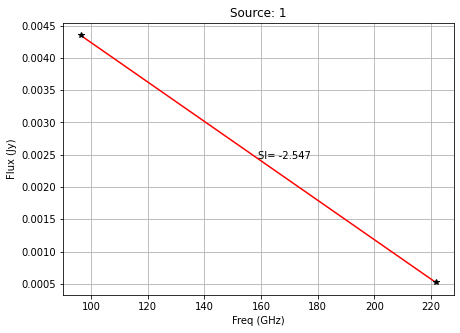

## Source: 2
[1, 3, 4]
[96.36457891463, 221.6343757654, 344.99460006879997]
[2.397065, 0.9998261, 0.992608]


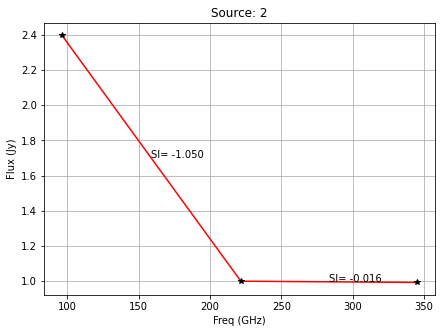

In [18]:
## spectral index and plot for each sources

nsource= 1
for s in sources:
    print("## Source: %d"%(nsource))
    print(s)
    
    fr= [frequency[i] for i in s]
    fl= [flux[i] for i in s]
    
    print(fr)
    print(fl)
    
    fig= plt.figure(figsize=(7,5))
    ax= plt.subplot(111)
    plt.title("Source: %d"%(nsource))
    plt.grid(True)
    plt.xlabel("Freq (GHz)")
    plt.ylabel("Flux (Jy)")
    plt.plot(fr, fl,"r-")
    plt.plot(fr, fl,"k*")
    
    for i in range(1,len(fr)):
        si= spectralIndex([fr[i-1],fr[i]],[fl[i-1],fl[i]] )
        plt.text(0.5*(fr[i-1]+fr[i]) , 0.5*(fl[i-1]+fl[i]) , "SI= %3.3f"%(si) )
    
    plt.show()
       
    nsource += 1
    